In [1]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, SimpleRNN 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
class Data:
    def __init__(self, player_name):
        self.player_name = player_name
        
    def extract_game_data(self, game):
        headers = game.headers
        white_player = headers.get('White', 'N/A')
        black_player = headers.get('Black', 'N/A')   
        white_elo_str = headers.get('WhiteElo', '')
        black_elo_str = headers.get('BlackElo', '')
        white_elo = int(white_elo_str) if white_elo_str else None
        black_elo = int(black_elo_str) if black_elo_str else None
        result = headers.get('Result', 'N/A')
        if result == '0-1':
            result_numeric = 0
        elif result == '1/2-1/2':
            result_numeric = 1
        elif result == '1-0':
            result_numeric = 2
        else: 
            result_numeric = 'N/A'    
        return white_player, black_player, white_elo, black_elo, result_numeric

    def game_data(self, pgn_file):
        white_player_list = []
        black_player_list = []
        white_elo_list = []
        black_elo_list = []
        result_list = []
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break
            white_player, black_player, white_elo, black_elo, result = self.extract_game_data(game)
            white_player_list.append(white_player)
            black_player_list.append(black_player)
            white_elo_list.append(white_elo)
            black_elo_list.append(black_elo)
            result_list.append(result)
        return white_player_list, black_player_list, white_elo_list, black_elo_list, result_list
    
    def get_data(self, pgn_file):
        with open(pgn_file, 'r') as pgn_file:
            potential_white_player, potential_black_player, potential_white_elo, potential_black_elo, potential_result = self.game_data(pgn_file)
        potential_data = np.array([potential_white_player, potential_black_player, potential_white_elo, potential_black_elo, potential_result]).T
        return potential_data

    def clear_data(self, pgn_file):
        potential_data = self.get_data(pgn_file)
        white_player_potential_data = potential_data[:, 0].astype(str)
        black_player_potential_data = potential_data[:, 1].astype(str)
        white_potential_data = np.array([int(x) if x is not None else 0 for x in potential_data[:, 2]])
        black_potential_data = np.array([int(x) if x is not None else 0 for x in potential_data[:, 3]])
        result_potential_data = np.array([int(x) if x != 'N/A' else 0 for x in potential_data[:, 4]])
        return white_player_potential_data, black_player_potential_data, white_potential_data, black_potential_data, result_potential_data

    def filter_white_data(self, pgn_file):
        white_player_potential_data, black_player_potential_data, white_potential_data, black_potential_data, result_potential_data = self.clear_data(pgn_file)
        full_data = []
        for (white_player, black_player, white_elo, black_elo, result) in zip(white_player_potential_data, black_player_potential_data, white_potential_data, black_potential_data, result_potential_data):
            if self.player_name in white_player:
                full_data.append([white_elo, black_elo, result])
        return np.array(full_data)
    
    def filter_black_data(self, pgn_file):
        white_player_potential_data, black_player_potential_data, white_potential_data, black_potential_data, result_potential_data = self.clear_data(pgn_file)
        full_data = []
        for (white_player, black_player, white_elo, black_elo, result) in zip(white_player_potential_data, black_player_potential_data, white_potential_data, black_potential_data, result_potential_data):
            if self.player_name in black_player:
                full_data.append([white_elo, black_elo, result])
        return np.array(full_data)
    
    def get_convert_black_to_white(self, pgn_file):
        black_data = self.filter_black_data(pgn_file)
        updated_results = [2 if x == 0 else (0 if x == 2 else x) for x in black_data[:, 2]]
        converted_black_to_white = np.vstack((black_data[:, 1], black_data[:, 0], updated_results)).T
        return converted_black_to_white
            
    def get_full_data(self, pgn_file):
        full_white_data = self.filter_white_data(pgn_file)
        full_black_data = self.get_convert_black_to_white(pgn_file)
        X_white = np.array([full_white_data[:, 0], full_white_data[:, 1]])
        X_white = list(zip(X_white[0], X_white[1]))
        y_white = list(full_white_data[:, 2])    
        X_black = np.array([full_black_data[:, 0], full_black_data[:, 1]])
        X_black = list(zip(X_black[0], X_black[1]))
        y_black = list(full_black_data[:, 2])
        X = X_white + X_black
        y = y_white + y_black
        return X, y
    
    def count_result(self, pgn_file):
        player_statistics = self.get_full_data(pgn_file)
        player_statistics = np.array(player_statistics[1])
        count_0 = np.count_nonzero(player_statistics == 0)
        count_1 = np.count_nonzero(player_statistics == 1)
        count_2 = np.count_nonzero(player_statistics == 2)
        return count_0, count_1, count_2
    
    def calculate_statistics(self, pgn_file):
        count_0, count_1, count_2 = self.count_result(pgn_file)
        player_statistics = self.get_full_data(pgn_file)
        player_statistics = np.array(player_statistics[1])
        percentage_0 = count_0 / len(player_statistics)
        percentage_1 = count_1 / len(player_statistics)
        percentage_2 = count_2 / len(player_statistics)
        return percentage_0, percentage_1, percentage_2
    
    def get_filtered_train_data(self, pgn_file, train_file_path):
        player_train_data = self.get_full_data(train_file_path)
        calculate_statistics = self.calculate_statistics(pgn_file)
        print(calculate_statistics)
        count_0, count_1, count_2 = self.count_result(train_file_path)
        y_train = player_train_data[1]
        total_results = len(y_train)
        elements_to_keep = [int(np.floor(total_results * percent)) for percent in calculate_statistics]
        indexes_to_keep_dict = {0: [], 1: [], 2: []}
        for i, label in enumerate(y_train):
            indexes_to_keep_dict[label].append(i)
        np.random.shuffle(indexes_to_keep_dict[0])
        np.random.shuffle(indexes_to_keep_dict[1])
        np.random.shuffle(indexes_to_keep_dict[2])
        indexes_to_keep_flat = np.concatenate([
            indexes_to_keep_dict[0][:min(count_0, elements_to_keep[0])],
            indexes_to_keep_dict[1][:min(count_1, elements_to_keep[1])],
            indexes_to_keep_dict[2][:min(count_2, elements_to_keep[2])]
        ])
        updated_y_train = [y_train[i] for i in indexes_to_keep_flat]
        filtered_train_data = ([player_train_data[0][i] for i in indexes_to_keep_flat], updated_y_train)
        return filtered_train_data

In [3]:
if __name__ == "__main__":
    player_data_path = 'C:\\Users\\KK\\Master Thesis\\dane\\database.pgn'
    train_file_path = 'C:\\Users\\KK\\Master Thesis\\dane\\\Caruana.pgn'
    player_name = "Caruana,F"
    class_data = Data(player_name) 

In [4]:
if __name__ == "__main__":
    X_Caruana, y_Caruana = class_data.get_filtered_train_data(player_data_path, train_file_path)
    X_train, X_test, y_train, y_test = train_test_split(X_Caruana, y_Caruana, train_size=0.8, test_size=0.2, random_state=42)
    X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)

illegal san: 'Nxf3' in rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1 while parsing <Game at 0x2ae4026f760 ('Lecomte,Robin' vs. 'Kalle,Erwin', '2023.03.11' at 'Netherlands NED')>
illegal san: 'Nxf3' in rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1 while parsing <Game at 0x2ae413a5a90 ('Lecomte,Robin' vs. 'Kalle,Erwin', '2023.03.11' at 'Netherlands NED')>
illegal san: 'Nxf3' in rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1 while parsing <Game at 0x2ae40de3dc0 ('Lecomte,Robin' vs. 'Kalle,Erwin', '2023.03.11' at 'Netherlands NED')>
illegal san: 'Nxf3' in rnbqkbnr/pppppppp/8/8/8/2N5/PPPPPPPP/R1BQKBNR b KQkq - 1 1 while parsing <Game at 0x2ae419c0610 ('Lecomte,Robin' vs. 'Kalle,Erwin', '2023.03.11' at 'Netherlands NED')>


(0.16744186046511628, 0.23255813953488372, 0.6)


<ipython-input-5-ed41ee7c2251>:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


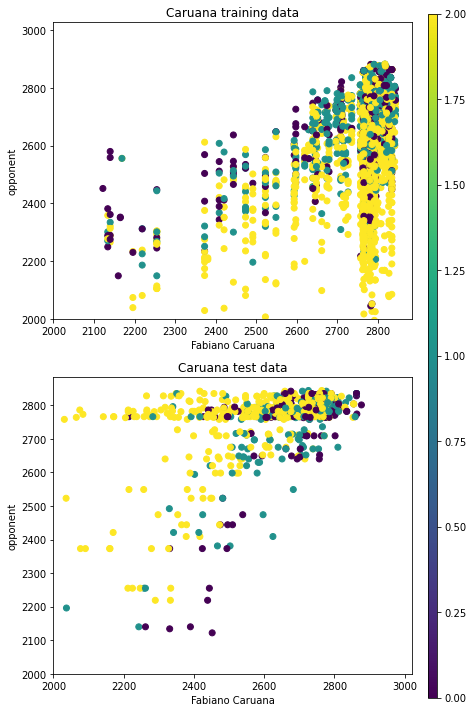

In [5]:
X_train_plot = list(zip(*X_train))
X_test_plot = list(zip(*X_test))

fig, axs = plt.subplots(2, 1, figsize=(6,10))

sc1 = axs[0].scatter(X_train_plot[0], X_train_plot[1], c=y_train)
axs[0].set_title('Caruana training data')
axs[0].set_xlabel('Fabiano Caruana')
axs[0].set_ylabel('opponent')
axs[0].set_xlim(2000)
axs[0].set_ylim(2000)

sc2 = axs[1].scatter(X_test_plot[1], X_test_plot[0], c=y_test)
axs[1].set_title('Caruana test data')
axs[1].set_xlabel('Fabiano Caruana')
axs[1].set_ylabel('opponent')
axs[1].set_xlim(2000)
axs[1].set_ylim(2000)


cax = fig.add_axes([1, 0.025, 0.02, 0.95])
cbar2 = plt.colorbar(sc2, cax=cax)
cbar2.set_label('')

plt.tight_layout()


# k-NN

In [33]:
class KNN:
    def __init__(self, X_train, y_train, X_test, y_test, k_neighbors):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.k_neighbors = k_neighbors
        self.model = None 

    def build_and_train_model(self):
        model = KNeighborsClassifier(n_neighbors=self.k_neighbors)
        model.fit(self.X_train, self.y_train)
        self.model = model
        accuracy = model.score(self.X_test, self.y_test)
        return accuracy

    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

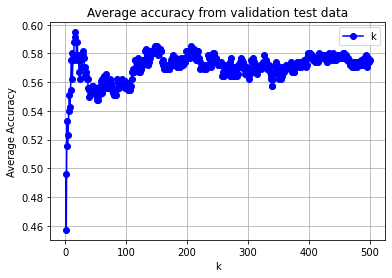

Best k from validation test data is: 17


In [59]:
k_neighbors_values = []
average_accuracy_values = []

for k in range(1, 501):
    accuracy_values_for_k = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_knn = KNN(X_validate, y_validate, X_test_validate, y_test_validate, k_neighbors=k)
        accuracy = model_knn.build_and_train_model()
        accuracy_values_for_k.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_k)
    k_neighbors_values.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(k_neighbors_values, average_accuracy_values, 'bo-', label='k')
plt.title('Average accuracy from validation test data')
plt.xlabel('k')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('KNN_Caruana1.jpg')
plt.show()

best_k = k_neighbors_values[np.argmax(average_accuracy_values)]
print(f"Best k from validation test data is: {best_k}")


No handles with labels found to put in legend.


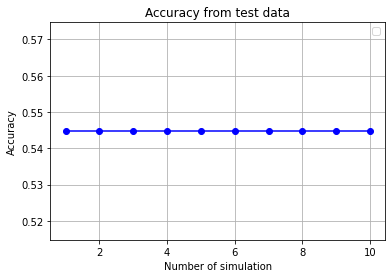

accuracy: 0.5447470817120622


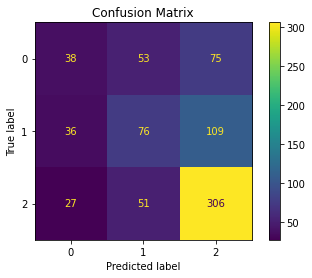

In [60]:
number_simulation_values = []
accuracy_values = []

for number_simulation in range(1, 11):
    model_knn = KNN(X_train, y_train, X_test, y_test, k_neighbors=17)
    accuracy = model_knn.build_and_train_model()
    number_simulation_values.append(number_simulation)
    accuracy_values.append(accuracy)

plt.plot(number_simulation_values, accuracy_values, 'bo-')
plt.title('Accuracy from test data')
plt.xlabel('Number of simulation')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('KNN_Caruana2.jpg')
plt.show()
print(f'accuracy: {accuracy}')

y_pred = model_knn.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


# Logistic Regression

In [61]:
class LR:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None 

    def build_and_train_model(self):
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        model = LogisticRegression(random_state=42, multi_class='multinomial')
        model.fit(X_train, y_train)
        self.model = model
        accuracy = model.score(X_test, y_test)
        return accuracy
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

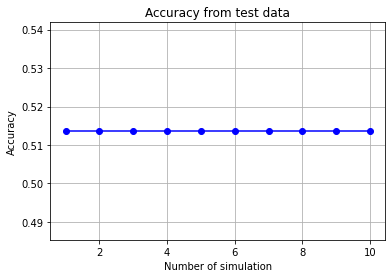

accuracy: 0.5136186770428015


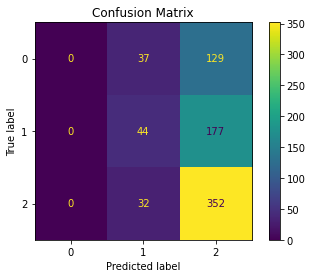

In [73]:
number_simulation_values = []
accuracy_values = []

for number_simulation in range(1, 11):
    model_LR = LR(X_train, y_train, X_test, y_test)
    accuracy = model_LR.build_and_train_model()
    number_simulation_values.append(number_simulation)
    accuracy_values.append(accuracy)

plt.plot(number_simulation_values, accuracy_values, 'bo-')
plt.title('Accuracy from test data')
plt.xlabel('Number of simulation')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('LR_Caruana.jpg')
plt.show()
print(f'accuracy: {accuracy}')

y_pred = model_LR.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Naive Bayes

In [74]:
class NB:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = None 

    def build_and_train_model(self):
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        model = MultinomialNB()
        model.fit(X_train, y_train)
        self.model = model
        accuracy = model.score(X_test, y_test)
        return accuracy
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

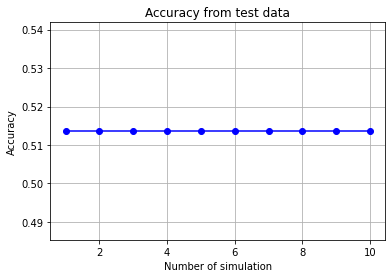

accuracy:0.5136186770428015


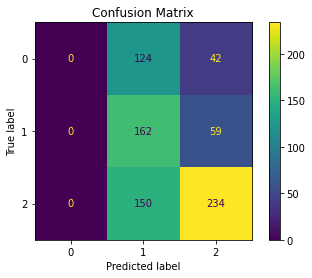

In [75]:
number_simulation_values = []
accuracy_values = []

for number_simulation in range(1, 11):
    model_NB = NB(X_train, y_train, X_test, y_test)
    accuracy = model_NB.build_and_train_model()
    number_simulation_values.append(number_simulation)
    accuracy_values.append(accuracy)

plt.plot(number_simulation_values, accuracy_values, 'bo-')
plt.title('Accuracy from test data')
plt.xlabel('Number of simulation')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('NB_Caruana.jpg')
plt.show()
print(f'accuracy:{accuracy}')

y_pred = model_NB.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# SVM

In [65]:
class SVM:
    def __init__(self, X_train, y_train, X_test, y_test, C):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.C = C
        self.model = None 
        
    def build_and_train_model(self):
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        model = SVC(C=self.C)
        model.fit(X_train, y_train)
        self.model = model
        accuracy = model.score(X_test, y_test)
        return accuracy
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

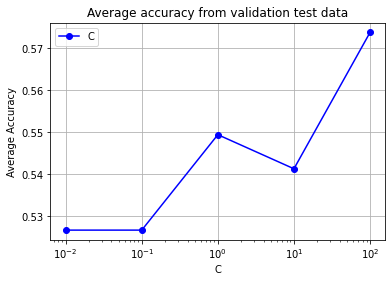

Best C from validation test data is: 100


In [66]:
C_values = [10**i for i in range(-2,3)]
C_list = []
average_accuracy_values = []

for k in C_values:
    accuracy_values_for_C = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_svm = SVM(X_validate, y_validate, X_test_validate, y_test_validate, C=k)
        accuracy = model_svm.build_and_train_model()
        accuracy_values_for_C.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_C)
    C_list.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(C_list, average_accuracy_values, 'bo-', label='C')
plt.title('Average accuracy from validation test data')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('SVM_Caruana1.jpg')
plt.show()

best_C = C_list[np.argmax(average_accuracy_values)]
print(f"Best C from validation test data is: {best_C}")

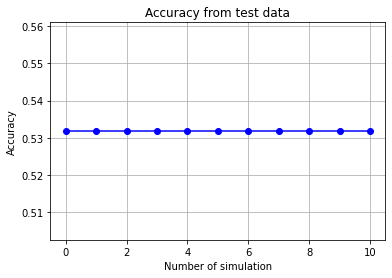

accuracy:0.5317769130998703


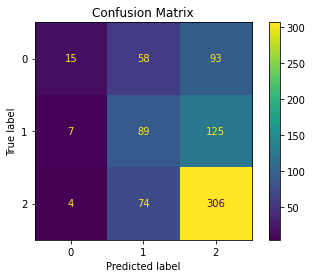

In [67]:
number_simulation_values = []
accuracy_values = []

for number_simulation in range(11):
    model_SVM = SVM(X_train, y_train, X_test, y_test, C=100)
    accuracy = model_SVM.build_and_train_model()
    number_simulation_values.append(number_simulation)
    accuracy_values.append(accuracy)

plt.plot(number_simulation_values, accuracy_values, 'bo-')
plt.title('Accuracy from test data')
plt.xlabel('Number of simulation')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig('SVM_Caruana2.jpg')
plt.show()
print(f'accuracy:{accuracy}')

y_pred = model_SVM.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Classification tree

In [68]:
class CT:
    def __init__(self, X_train, y_train, X_test, y_test, min_samples_split, min_samples_leaf):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.model = None 

    def build_and_train_model(self):
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        model = DecisionTreeClassifier(random_state=42, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
        model.fit(X_train, y_train)
        self.model = model
        accuracy = model.score(X_test, y_test)
        return accuracy
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

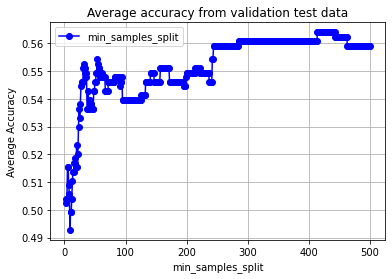

Best min_samples_split from validation test data is: 414


In [69]:
min_samples_split_values = [i for i in range(2,501)]
min_samples_split_list = []
average_accuracy_values = []

for k in min_samples_split_values:
    accuracy_values_for_min_samples_split_list = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_CT = CT(X_validate, y_validate, X_test_validate, y_test_validate, min_samples_split=k, min_samples_leaf=1)
        accuracy = model_CT.build_and_train_model()
        accuracy_values_for_min_samples_split_list.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_min_samples_split_list)
    min_samples_split_list.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(min_samples_split_list, average_accuracy_values, 'bo-', label='min_samples_split')
plt.title('Average accuracy from validation test data')
plt.xlabel('min_samples_split')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('CT_Caruana1.jpg')
plt.show()

best_min_samples_split = min_samples_split_list[np.argmax(average_accuracy_values)]
print(f"Best min_samples_split from validation test data is: {best_min_samples_split}")

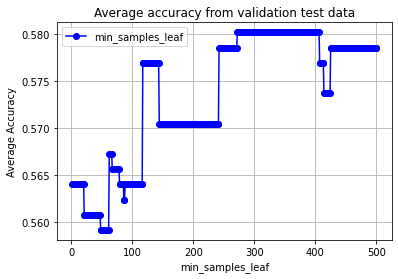

Best min_samples_leaf from validation test data is: 272


In [76]:
min_samples_leaf_values = [i for i in range(1,501)]
min_samples_leaf_list = []
average_accuracy_values = []

for k in min_samples_leaf_values:
    accuracy_values_for_min_samples_leaf_list = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_CT = CT(X_validate, y_validate, X_test_validate, y_test_validate, min_samples_split=414, min_samples_leaf=k)
        accuracy = model_CT.build_and_train_model()
        accuracy_values_for_min_samples_leaf_list.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_min_samples_leaf_list)
    min_samples_leaf_list.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(min_samples_leaf_list, average_accuracy_values, 'bo-', label='min_samples_leaf')
plt.title('Average accuracy from validation test data')
plt.xlabel('min_samples_leaf')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('CT_Caruana2.jpg')
plt.show()

best_min_samples_leaf = min_samples_leaf_list[np.argmax(average_accuracy_values)]
print(f"Best min_samples_leaf from validation test data is: {best_min_samples_leaf}")

No handles with labels found to put in legend.


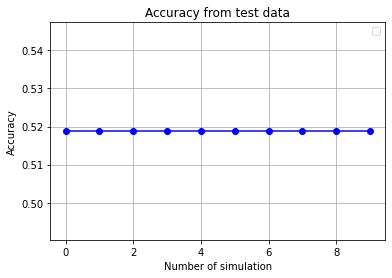

accuracy:0.5188067444876784


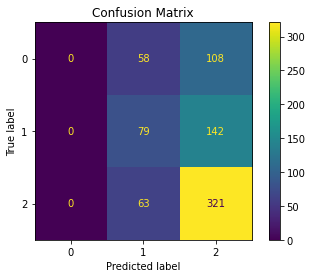

In [77]:
number_simulation_values = []
accuracy_values = []

for number_simulation in range(10):
    model_CT = CT(X_train, y_train, X_test, y_test, min_samples_split=414, min_samples_leaf=272)
    accuracy = model_CT.build_and_train_model()
    number_simulation_values.append(number_simulation)
    accuracy_values.append(accuracy)

plt.plot(number_simulation_values, accuracy_values, 'bo-')
plt.title('Accuracy from test data')
plt.xlabel('Number of simulation')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('CT_Caruana3.jpg')
plt.show()
print(f'accuracy:{accuracy}')

y_pred = model_CT.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Random forest

In [78]:
class RF:
    def __init__(self, X_train, y_train, X_test, y_test, n_estimators, min_samples_split, min_samples_leaf):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def build_and_train_model(self):
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        model = RandomForestClassifier(random_state=42, n_estimators=self.n_estimators, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf)
        model.fit(X_train, y_train)
        self.model = model
        accuracy = model.score(X_test, y_test)
        return accuracy
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

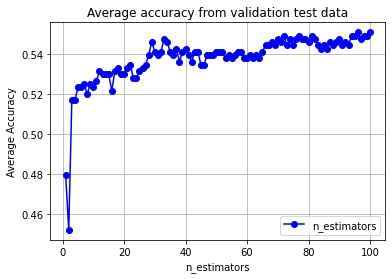

Best n_estimators from validation test data is: 96


In [79]:
n_estimators_values = [i for i in range(1,101)]
n_estimators_list = []
average_accuracy_values = []

for k in n_estimators_values:
    accuracy_values_for_n_estimators_list = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_RF = RF(X_validate, y_validate, X_test_validate, y_test_validate, n_estimators=k, min_samples_split=2, min_samples_leaf=1)
        accuracy = model_RF.build_and_train_model()
        accuracy_values_for_n_estimators_list.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_n_estimators_list)
    n_estimators_list.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(n_estimators_list, average_accuracy_values, 'bo-', label='n_estimators')
plt.title('Average accuracy from validation test data')
plt.xlabel('n_estimators')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('RF_Caruana1.jpg')
plt.show()

best_n_estimators = n_estimators_list[np.argmax(average_accuracy_values)]
print(f"Best n_estimators from validation test data is: {best_n_estimators}")

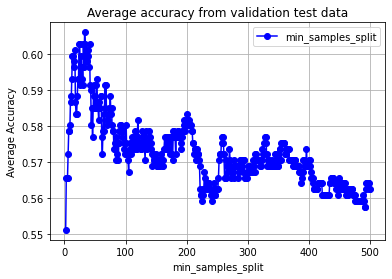

Best min_samples_split from validation test data is: 33


In [80]:
min_samples_split_values = [i for i in range(2,501)]
min_samples_split_list = []
average_accuracy_values = []

for k in min_samples_split_values:
    accuracy_values_for_min_samples_split_list = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_RF = RF(X_validate, y_validate, X_test_validate, y_test_validate, n_estimators=96, min_samples_split=k, min_samples_leaf=1)
        accuracy = model_RF.build_and_train_model()
        accuracy_values_for_min_samples_split_list.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_min_samples_split_list)
    min_samples_split_list.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(min_samples_split_list, average_accuracy_values, 'bo-', label='min_samples_split')
plt.title('Average accuracy from validation test data')
plt.xlabel('min_samples_split')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('RF_Caruana2.jpg')
plt.show()

best_min_samples_split = min_samples_split_list[np.argmax(average_accuracy_values)]
print(f"Best min_samples_split from validation test data is: {best_min_samples_split}")

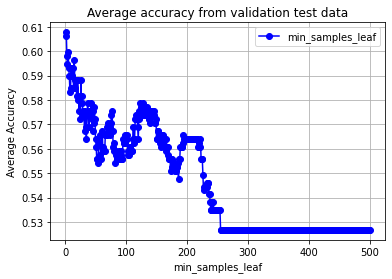

Best min_samples_leaf from validation test data is: 2


In [81]:
min_samples_leaf_values = [i for i in range(1,501)]
min_samples_leaf_list = []
average_accuracy_values = []

for k in min_samples_leaf_values:
    accuracy_values_for_min_samples_leaf_list = []
    for number_simulation in range(10):
        X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=42)
        model_RF = RF(X_validate, y_validate, X_test_validate, y_test_validate, n_estimators=96, min_samples_split=33, min_samples_leaf=k)
        accuracy = model_RF.build_and_train_model()
        accuracy_values_for_min_samples_leaf_list.append(accuracy)
    average_accuracy = np.mean(accuracy_values_for_min_samples_leaf_list)
    min_samples_leaf_list.append(k)
    average_accuracy_values.append(average_accuracy)

plt.plot(min_samples_leaf_list, average_accuracy_values, 'bo-', label='min_samples_leaf')
plt.title('Average accuracy from validation test data')
plt.xlabel('min_samples_leaf')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('RF_Caruana3.jpg')
plt.show()

best_min_samples_leaf = min_samples_leaf_list[np.argmax(average_accuracy_values)]
print(f"Best min_samples_leaf from validation test data is: {best_min_samples_leaf}")

No handles with labels found to put in legend.


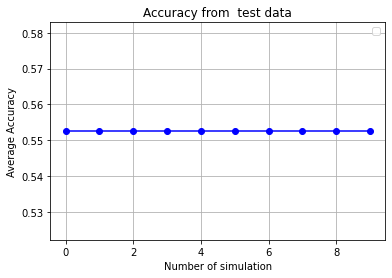

accuracy:0.5525291828793775


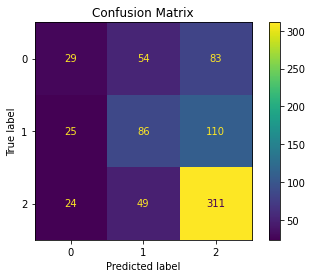

In [85]:
number_simulation_values = []
accuracy_values = []

for number_simulation in range(10):
    model_RF = RF(X_train, y_train, X_test, y_test, n_estimators=96, min_samples_split=33, min_samples_leaf=2)
    accuracy = model_RF.build_and_train_model()
    number_simulation_values.append(number_simulation)
    accuracy_values.append(accuracy)

plt.plot(number_simulation_values, accuracy_values, 'bo-')
plt.title('Accuracy from  test data')
plt.xlabel('Number of simulation')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('RF_Caruana4.jpg')
plt.show()
print(f'accuracy:{accuracy}')

y_pred = model_RF.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# Bagging

In [87]:
class Bagging:
    def __init__(self, X_train, y_train, X_test, y_test, base_model, n_estimators):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.base_model = base_model
        self.n_estimators = n_estimators

    def build_and_train_model(self):
        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        base_model = self.base_model
        if model_type == 'k-NN':
            base_model = KNeighborsClassifier(n_neighbors=17)
        elif model_type == 'Logistic regression':
            base_model = LogisticRegression(random_state=42, multi_class='multinomial')              
        elif model_type == 'Naive Bayes':
            base_model = MultinomialNB()
        elif model_type == 'SVM':
            base_model = SVC(C=100)
        elif model_type == 'Classification tree':
            base_model = DecisionTreeClassifier(random_state=42, min_samples_split=414, min_samples_leaf=272)
        elif model_type == 'Random forest':
            base_model = RandomForestClassifier(random_state=42, n_estimators=96, min_samples_split=33, min_samples_leaf=2)
        else:
            raise ValueError("Invalid model type. Choose 'knn', 'logistic_regression', 'naive_bayes', 'svm', 'classification_tree' or 'random_forest'.")
        model = BaggingClassifier(base_model, random_state=42, n_estimators=self.n_estimators)
        model.fit(X_train, y_train)
        self.model = model
        accuracy = model.score(X_test, y_test)
        return accuracy
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        return self.model.predict(X)

k-NN  (best n_estimators=6) accuracy:[0.5213938411669368, 0.5487844408427877, 0.5491085899513776, 0.5460291734197731, 0.5513776337115073, 0.5517017828200973, 0.5380875202593192, 0.5492706645056726, 0.546515397082658, 0.5387358184764992]
Logistic regression  (best n_estimators=10) accuracy:[0.5393841166936791, 0.5382495948136142, 0.53354943273906, 0.5351701782820097, 0.5392220421393841, 0.533063209076175, 0.5330632090761751, 0.5393841166936791, 0.5354943273905997, 0.5416531604538087]
Naive Bayes  (best n_estimators=2) accuracy:[0.5209076175040519, 0.5273905996758509, 0.5205834683954619, 0.5183144246353323, 0.5175040518638573, 0.5272285251215559, 0.526580226904376, 0.5150729335494327, 0.5176661264181524, 0.5256077795786062]
SVM  (best n_estimators=10) accuracy:[0.5345218800648299, 0.5528363047001621, 0.5497568881685575, 0.5408427876823338, 0.5465153970826581, 0.5536466774716369, 0.5408427876823338, 0.5423014586709887, 0.5481361426256077, 0.553808752025932]
Classification tree  (best n_es

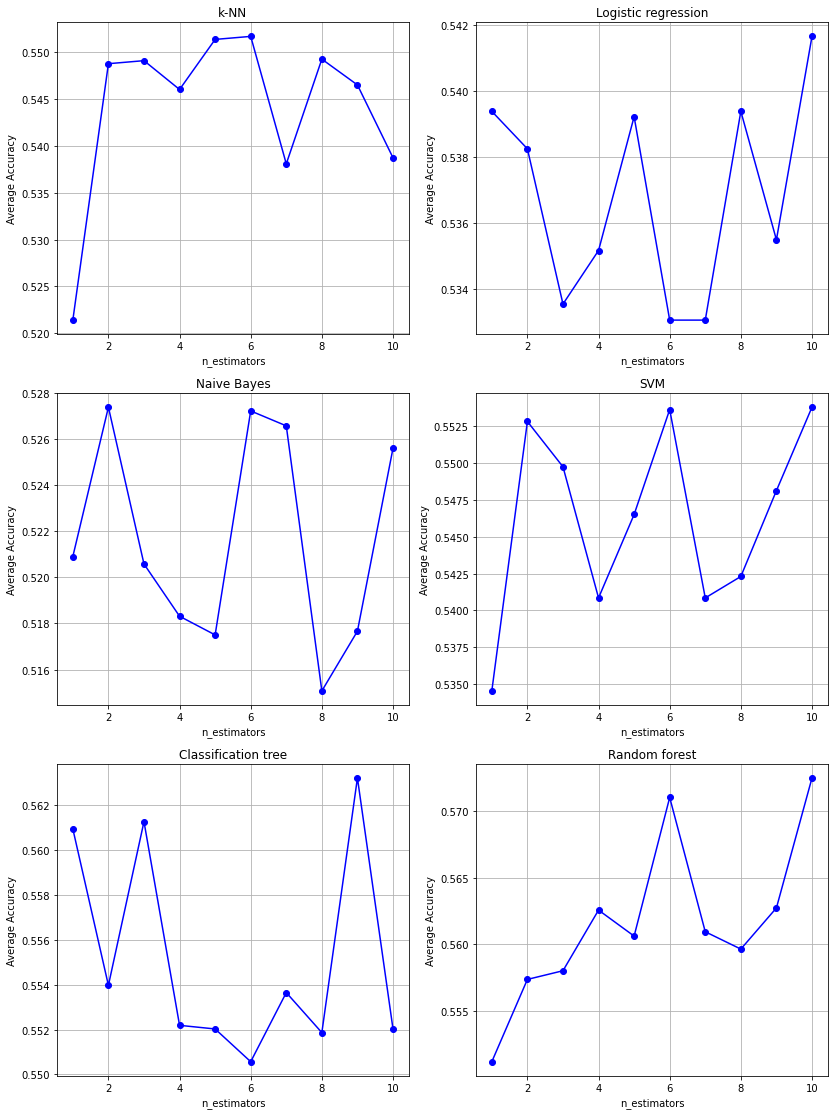

In [91]:
models = {
    'k-NN': KNeighborsClassifier(n_neighbors=17),
    'Logistic regression': LogisticRegression(random_state=42, multi_class='multinomial'),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(C=100),
    'Classification tree': DecisionTreeClassifier(random_state=42, min_samples_split=414, min_samples_leaf=272),
    'Random forest': RandomForestClassifier(random_state=42, n_estimators=96, min_samples_split=33, min_samples_leaf=2)
}

fig, axs = plt.subplots(3, 2, figsize=(11.7, 15.6))

for i, (model_type, base_model) in enumerate(models.items()):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    n_estimators_values = range(1, 11)
    average_accuracy_values = []

    for n_estimators in n_estimators_values:
        accuracy_values_for_n_estimators_list = []
        for j in range(10):
            X_validate, X_test_validate, y_validate, y_test_validate = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2)
            bagging_model = BaggingClassifier(base_model, n_estimators=n_estimators)
            bagging_model.fit(X_validate, y_validate)
            accuracy = bagging_model.score(X_test_validate, y_test_validate)
            accuracy_values_for_n_estimators_list.append(accuracy)
        average_accuracy = np.mean(accuracy_values_for_n_estimators_list)
        average_accuracy_values.append(average_accuracy)

    best_n_estimators = n_estimators_values[np.argmax(average_accuracy_values)]

    ax.plot(n_estimators_values, average_accuracy_values, 'bo-')
    ax.set_title(model_type)
    print(model_type, f" (best n_estimators={best_n_estimators})", f"accuracy:{average_accuracy_values}")
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('Average Accuracy')
    ax.grid(True)

plt.tight_layout()
plt.savefig('Bagging_Caruana.jpg')
plt.show()

k-NN accuracy: [0.5395590142671854, 0.5317769130998703, 0.5317769130998703, 0.5369649805447471, 0.5343709468223087, 0.5590142671854734, 0.5330739299610895, 0.5317769130998703, 0.5395590142671854, 0.5421530479896238]


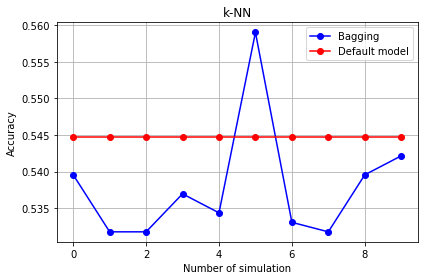

In [92]:
models = {
    'k-NN': (KNeighborsClassifier(n_neighbors=17), 6)
}

fig, ax = plt.subplots(1, 1)

for i, (model_type, (base_model, n_estimators)) in enumerate(models.items()):
    accuracy_values_for_n_simulations_list = []
    number_simulations_list = []
    for j in range(10):
        bagging_model = BaggingClassifier(base_model, n_estimators=n_estimators)
        bagging_model.fit(X_train, y_train)
        accuracy = bagging_model.score(X_test, y_test)
        number_simulations_list.append(j)
        accuracy_values_for_n_simulations_list.append(accuracy)
    
    ax.plot(number_simulations_list, accuracy_values_for_n_simulations_list, 'bo-', label='Bagging')
    
    base_model.fit(X_train, y_train)
    accuracy = base_model.score(X_test, y_test)
    ax.plot(number_simulations_list, [accuracy] * len(number_simulations_list), 'ro-', label='Default model')
    
    ax.set_title(model_type)
    print(model_type, f"accuracy: {accuracy_values_for_n_simulations_list}")
    ax.set_xlabel('Number of simulation')
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('Bagging_Caruana21.jpg')
plt.show()

Logistic regression accuracy: [0.5123216601815823, 0.5188067444876784, 0.5110246433203631, 0.522697795071336, 0.5214007782101168, 0.5136186770428015, 0.522697795071336, 0.5110246433203631, 0.5201037613488976, 0.5201037613488976]
Naive Bayes accuracy: [0.5188067444876784, 0.51621271076524, 0.5201037613488976, 0.51621271076524, 0.51621271076524, 0.5149156939040207, 0.5188067444876784, 0.5188067444876784, 0.5214007782101168, 0.5214007782101168]


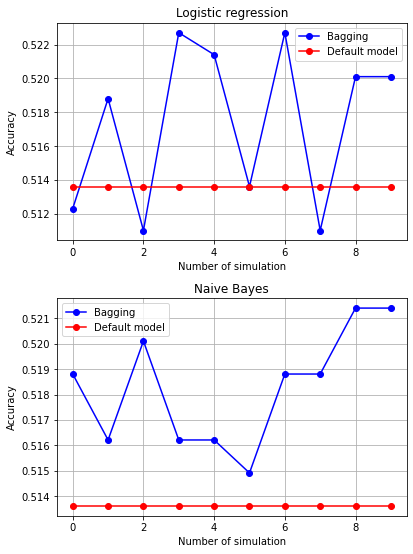

In [93]:
models = {
    'Logistic regression': (LogisticRegression(random_state=42, multi_class='multinomial'), 10),
    'Naive Bayes': (MultinomialNB(), 2)
}

fig, axs = plt.subplots(2, 1, figsize=(5.85, 7.8))

for i, (model_type, (base_model, n_estimators)) in enumerate(models.items()):
    ax = axs[i] 
    accuracy_values_for_n_simulations_list = []
    number_simulations_list = []
    for j in range(10):
        bagging_model = BaggingClassifier(base_model, n_estimators=n_estimators)
        bagging_model.fit(X_train, y_train)
        accuracy = bagging_model.score(X_test, y_test)
        number_simulations_list.append(j)
        accuracy_values_for_n_simulations_list.append(accuracy)
    ax.plot(number_simulations_list, accuracy_values_for_n_simulations_list, 'bo-', label='Bagging')
    
    base_model.fit(X_train, y_train)
    accuracy = base_model.score(X_test, y_test)
    ax.plot(number_simulations_list, [accuracy] * len(number_simulations_list), 'ro-', label='Default model')
    
    ax.set_title(model_type)
    print(model_type, f"accuracy: {accuracy_values_for_n_simulations_list}")
    ax.set_xlabel('Number of simulation')
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('Bagging_Caruana22.jpg')
plt.show()

Classification tree accuracy: [0.522697795071336, 0.5175097276264592, 0.5214007782101168, 0.522697795071336, 0.5188067444876784, 0.5175097276264592, 0.5265888456549935, 0.5201037613488976, 0.5239948119325551, 0.5214007782101168]
Random forest accuracy: [0.5317769130998703, 0.5317769130998703, 0.5395590142671854, 0.5408560311284046, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5382619974059663, 0.5317769130998703, 0.5330739299610895]


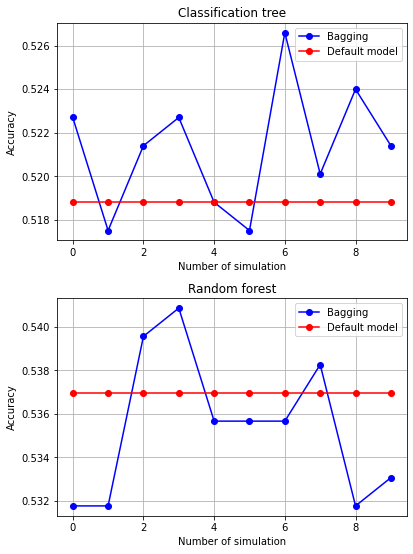

In [94]:
models = {
    'Classification tree': (DecisionTreeClassifier(random_state=42, min_samples_split=288, min_samples_leaf=233), 9),
    'Random forest': (RandomForestClassifier(random_state=42, n_estimators=77, min_samples_split=152, min_samples_leaf=1), 10)
}

fig, axs = plt.subplots(2, 1, figsize=(5.85, 7.8))

for i, (model_type, (base_model, n_estimators)) in enumerate(models.items()):
    ax = axs[i] 
    accuracy_values_for_n_simulations_list = []
    number_simulations_list = []
    for j in range(10):
        bagging_model = BaggingClassifier(base_model, n_estimators=n_estimators)
        bagging_model.fit(X_train, y_train)
        accuracy = bagging_model.score(X_test, y_test)
        number_simulations_list.append(j)
        accuracy_values_for_n_simulations_list.append(accuracy)
    ax.plot(number_simulations_list, accuracy_values_for_n_simulations_list, 'bo-', label='Bagging')
    
    base_model.fit(X_train, y_train)
    accuracy = base_model.score(X_test, y_test)
    ax.plot(number_simulations_list, [accuracy] * len(number_simulations_list), 'ro-', label='Default model')
    
    ax.set_title(model_type)
    print(model_type, f"accuracy: {accuracy_values_for_n_simulations_list}")
    ax.set_xlabel('Number of simulation')
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('Bagging_Caruana23.jpg')
plt.show()

SVM accuracy: [0.5278858625162127, 0.5252918287937743, 0.5252918287937743, 0.5291828793774319, 0.5304798962386511, 0.5330739299610895, 0.5239948119325551, 0.5265888456549935, 0.5343709468223087, 0.5291828793774319]


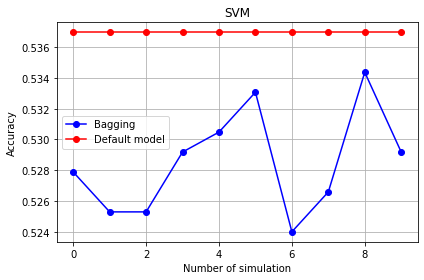

In [27]:
models = {
    'SVM': (SVC(C=100), 10)
}

fig, ax = plt.subplots(1, 1)

for i, (model_type, (base_model, n_estimators)) in enumerate(models.items()):
    accuracy_values_for_n_simulations_list = []
    number_simulations_list = []
    for j in range(10):
        bagging_model = BaggingClassifier(base_model, n_estimators=n_estimators)
        bagging_model.fit(X_train, y_train)
        accuracy = bagging_model.score(X_test, y_test)
        number_simulations_list.append(j)
        accuracy_values_for_n_simulations_list.append(accuracy)
    
    ax.plot(number_simulations_list, accuracy_values_for_n_simulations_list, 'bo-', label='Bagging')
    
    base_model.fit(X_train, y_train)
    accuracy = base_model.score(X_test, y_test)
    ax.plot(number_simulations_list, [accuracy] * len(number_simulations_list), 'ro-', label='Default model')
    
    ax.set_title(model_type)
    print(model_type, f"accuracy: {accuracy_values_for_n_simulations_list}")
    ax.set_xlabel('Number of simulation')
    ax.set_ylabel('Accuracy')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('Bagging_Caruana24.jpg')
plt.show()

# Boosting

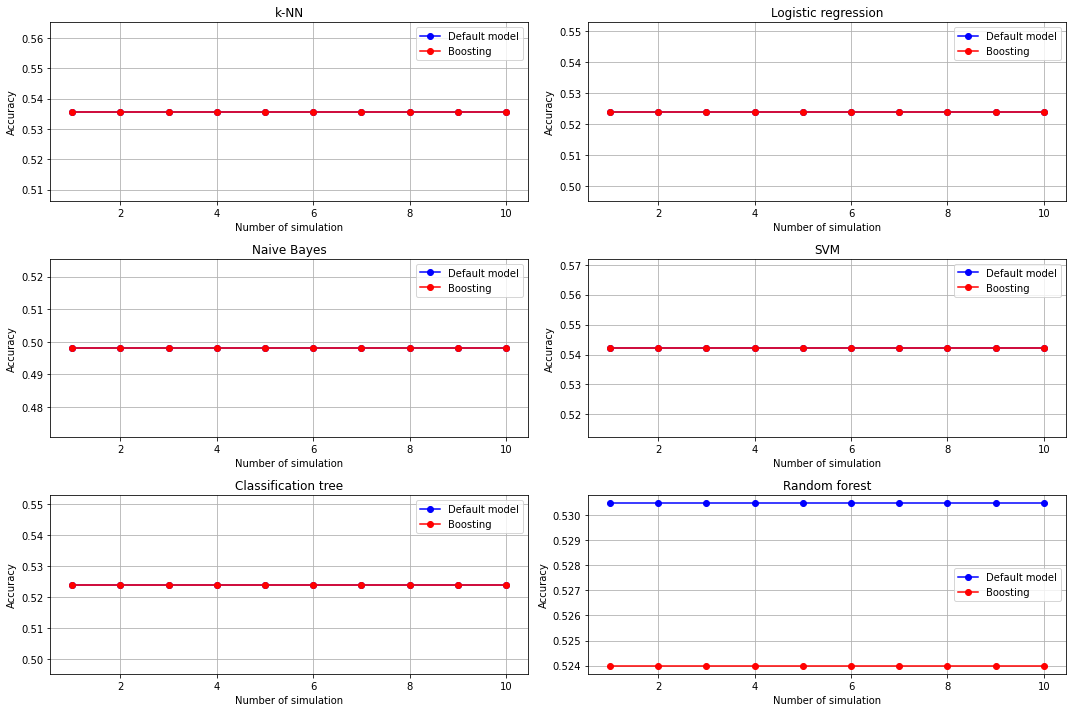

k-NN: [0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279, 0.5356679636835279]
Logistic regression: [0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551]
Naive Bayes: [0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712, 0.4980544747081712]
SVM: [0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238, 0.5421530479896238]
Classification tree: [0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948119325551, 0.5239948

In [89]:
parameters = {
    'objective': 'multi:softmax',
    'num_class': 3
}


knn_accuracies = []
xgb_accuracies_00 = []
lr_accuracies = []
xgb_accuracies_01 = []
nb_accuracies = []
xgb_accuracies_10 = []
svm_accuracies = []
xgb_accuracies_11 = []
ct_accuracies = []
xgb_accuracies_20 = []
rf_accuracies = []
xgb_accuracies_21 = []


for j in range(10):
    knn_model = KNeighborsClassifier(n_neighbors=120)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    knn_accuracies.append(knn_accuracy)

    xgb_model_knn = xgb.train(parameters, xgb.DMatrix(knn_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_knn = xgb.DMatrix(knn_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_knn = xgb_model_knn.predict(dtest_knn)
    xgb_accuracy_knn = accuracy_score(y_test, xgb_predictions_knn)
    xgb_accuracies_00.append(xgb_accuracy_knn)

    lr_model = LogisticRegression(random_state=42, multi_class='multinomial')
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    lr_accuracies.append(lr_accuracy)

    xgb_model_lr = xgb.train(parameters, xgb.DMatrix(lr_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_lr = xgb.DMatrix(lr_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_lr = xgb_model_lr.predict(dtest_lr)
    xgb_accuracy_lr = accuracy_score(y_test, xgb_predictions_lr)
    xgb_accuracies_01.append(xgb_accuracy_lr) 

    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    nb_predictions = nb_model.predict(X_test)
    nb_accuracy = accuracy_score(y_test, nb_predictions)
    nb_accuracies.append(nb_accuracy)

    xgb_model_nb = xgb.train(parameters, xgb.DMatrix(nb_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_nb = xgb.DMatrix(nb_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_nb = xgb_model_nb.predict(dtest_nb)
    xgb_accuracy_nb = accuracy_score(y_test, xgb_predictions_nb)
    xgb_accuracies_10.append(xgb_accuracy_nb) 

    svm_model = SVC(C=100)
    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    svm_accuracies.append(svm_accuracy)

    xgb_model_svm = xgb.train(parameters, xgb.DMatrix(svm_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_svm = xgb.DMatrix(svm_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_svm = xgb_model_svm.predict(dtest_svm)
    xgb_accuracy_svm = accuracy_score(y_test, xgb_predictions_svm)
    xgb_accuracies_11.append(xgb_accuracy_svm)

    ct_model = DecisionTreeClassifier(random_state=42, min_samples_split=288, min_samples_leaf=233)
    ct_model.fit(X_train, y_train)
    ct_predictions = ct_model.predict(X_test)
    ct_accuracy = accuracy_score(y_test, ct_predictions)
    ct_accuracies.append(ct_accuracy)

    xgb_model_ct = xgb.train(parameters, xgb.DMatrix(ct_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_ct = xgb.DMatrix(ct_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_ct = xgb_model_svm.predict(dtest_ct)
    xgb_accuracy_ct = accuracy_score(y_test, xgb_predictions_ct)
    xgb_accuracies_20.append(xgb_accuracy_ct)

    rf_model = RandomForestClassifier(random_state=42, n_estimators=77, min_samples_split=152, min_samples_leaf=1)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    rf_accuracies.append(rf_accuracy)

    xgb_model_rf = xgb.train(parameters, xgb.DMatrix(ct_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_rf = xgb.DMatrix(ct_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_rf = xgb_model_svm.predict(dtest_rf)
    xgb_accuracy_rf = accuracy_score(y_test, xgb_predictions_rf)
    xgb_accuracies_21.append(xgb_accuracy_rf)
        
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

axes[0, 0].plot(range(1,11), knn_accuracies, 'bo-', label='Default model')
axes[0, 0].plot(range(1,11), xgb_accuracies_00, 'ro-', label='Boosting')
axes[0, 0].set_title('k-NN')
axes[0, 0].set_xlabel('Number of simulation')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(range(1,11), lr_accuracies, 'bo-', label='Default model')
axes[0, 1].plot(range(1,11), xgb_accuracies_01, 'ro-', label='Boosting')
axes[0, 1].set_title('Logistic regression')
axes[0, 1].set_xlabel('Number of simulation')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(range(1,11), nb_accuracies, 'bo-', label='Default model')
axes[1, 0].plot(range(1,11), xgb_accuracies_10, 'ro-', label='Boosting')
axes[1, 0].set_title('Naive Bayes')
axes[1, 0].set_xlabel('Number of simulation')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(range(1,11), svm_accuracies, 'bo-', label='Default model')
axes[1, 1].plot(range(1,11), xgb_accuracies_11, 'ro-', label='Boosting')
axes[1, 1].set_title('SVM')
axes[1, 1].set_xlabel('Number of simulation')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

axes[2, 0].plot(range(1,11), ct_accuracies, 'bo-', label='Default model')
axes[2, 0].plot(range(1,11), xgb_accuracies_20, 'ro-', label='Boosting')
axes[2, 0].set_title('Classification tree')
axes[2, 0].set_xlabel('Number of simulation')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(range(1,11), rf_accuracies, 'bo-', label='Default model')
axes[2, 1].plot(range(1,11), xgb_accuracies_21, 'ro-', label='Boosting')
axes[2, 1].set_title('Random forest')
axes[2, 1].set_xlabel('Number of simulation')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.savefig('Boosting_Caruana.jpg')
plt.show()

print(f"k-NN: {xgb_accuracies_00}")
print(f"Logistic regression: {xgb_accuracies_01}")
print(f"Naive Bayes: {xgb_accuracies_10}")
print(f"SVM: {xgb_accuracies_11}")
print(f"Classification tree: {xgb_accuracies_20}")
print(f"Random forest: {xgb_accuracies_21}")

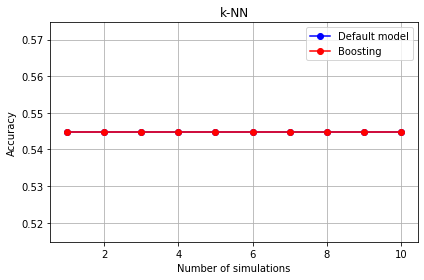

k-NN with Boosting: [0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622, 0.5447470817120622]


In [110]:
parameters = {
    'objective': 'multi:softmax',
    'num_class': 3
}

knn_accuracies = []
xgb_accuracies_00 = []

for j in range(10):
    knn_model = KNeighborsClassifier(n_neighbors=17)
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    knn_accuracies.append(knn_accuracy)

    xgb_model_knn = xgb.train(parameters, xgb.DMatrix(knn_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_knn = xgb.DMatrix(knn_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_knn = xgb_model_knn.predict(dtest_knn)
    xgb_accuracy_knn = accuracy_score(y_test, xgb_predictions_knn)
    xgb_accuracies_00.append(xgb_accuracy_knn)
    
plt.figure()
plt.plot(range(1, 11), knn_accuracies, 'bo-', label='Default model')
plt.plot(range(1, 11), xgb_accuracies_00, 'ro-', label='Boosting')
plt.title('k-NN')
plt.xlabel('Number of simulations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Boosting_Caruana1.jpg')
plt.show()

print(f"k-NN with Boosting: {xgb_accuracies_00}")

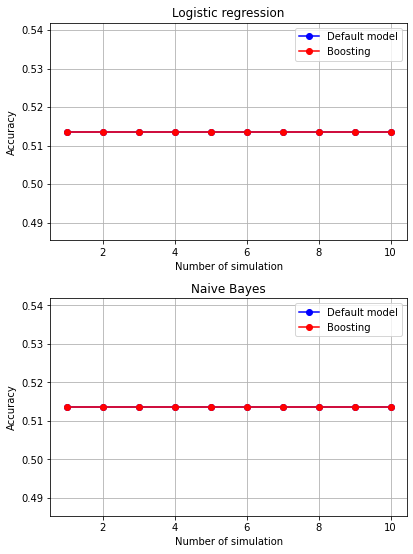

Logistic regression: [0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015]
Naive Bayes: [0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015, 0.5136186770428015]


In [102]:
parameters = {
    'objective': 'multi:softmax',
    'num_class': 3
}

lr_accuracies = []
xgb_accuracies_01 = []
nb_accuracies = []
xgb_accuracies_10 = []

for j in range(10):

    lr_model = LogisticRegression(random_state=42, multi_class='multinomial')
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_predictions)
    lr_accuracies.append(lr_accuracy)

    xgb_model_lr = xgb.train(parameters, xgb.DMatrix(lr_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_lr = xgb.DMatrix(lr_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_lr = xgb_model_lr.predict(dtest_lr)
    xgb_accuracy_lr = accuracy_score(y_test, xgb_predictions_lr)
    xgb_accuracies_01.append(xgb_accuracy_lr) 
    
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    nb_predictions = nb_model.predict(X_test)
    nb_accuracy = accuracy_score(y_test, nb_predictions)
    nb_accuracies.append(nb_accuracy)

    xgb_model_nb = xgb.train(parameters, xgb.DMatrix(nb_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_nb = xgb.DMatrix(nb_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_nb = xgb_model_nb.predict(dtest_nb)
    xgb_accuracy_nb = accuracy_score(y_test, xgb_predictions_nb)
    xgb_accuracies_10.append(xgb_accuracy_nb) 

fig, axes = plt.subplots(2, 1, figsize=(5.85, 7.8))
    
axes[0].plot(range(1,11), lr_accuracies, 'bo-', label='Default model')
axes[0].plot(range(1,11), xgb_accuracies_01, 'ro-', label='Boosting')
axes[0].set_title('Logistic regression')
axes[0].set_xlabel('Number of simulation')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(1,11), nb_accuracies, 'bo-', label='Default model')
axes[1].plot(range(1,11), xgb_accuracies_10, 'ro-', label='Boosting')
axes[1].set_title('Naive Bayes')
axes[1].set_xlabel('Number of simulation')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()

plt.savefig('Boosting_Caruana2.jpg')
plt.show()

print(f"Logistic regression: {xgb_accuracies_01}")
print(f"Naive Bayes: {xgb_accuracies_10}")

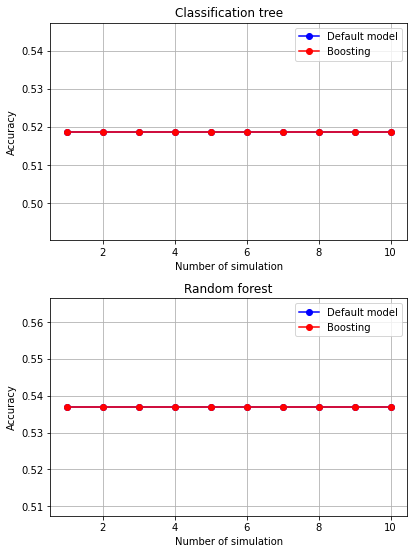

Classification tree: [0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784, 0.5188067444876784]
Random forest: [0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471, 0.5369649805447471]


In [104]:
parameters = {
    'objective': 'multi:softmax',
    'num_class': 3
}

ct_accuracies = []
xgb_accuracies_20 = []
rf_accuracies = []
xgb_accuracies_21 = []

for j in range(10):
    ct_model = DecisionTreeClassifier(random_state=42, min_samples_split=288, min_samples_leaf=233)
    ct_model.fit(X_train, y_train)
    ct_predictions = ct_model.predict(X_test)
    ct_accuracy = accuracy_score(y_test, ct_predictions)
    ct_accuracies.append(ct_accuracy)

    xgb_model_ct = xgb.train(parameters, xgb.DMatrix(ct_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_ct = xgb.DMatrix(ct_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_ct = xgb_model_svm.predict(dtest_ct)
    xgb_accuracy_ct = accuracy_score(y_test, xgb_predictions_ct)
    xgb_accuracies_20.append(xgb_accuracy_ct)

    rf_model = RandomForestClassifier(random_state=42, n_estimators=77, min_samples_split=152, min_samples_leaf=1)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_predictions)
    rf_accuracies.append(rf_accuracy)

    xgb_model_rf = xgb.train(parameters, xgb.DMatrix(rf_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_rf = xgb.DMatrix(rf_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_rf = xgb_model_svm.predict(dtest_rf)
    xgb_accuracy_rf = accuracy_score(y_test, xgb_predictions_rf)
    xgb_accuracies_21.append(xgb_accuracy_rf)

fig, axes = plt.subplots(2, 1, figsize=(5.85, 7.8))
    
axes[0].plot(range(1,11), ct_accuracies, 'bo-', label='Default model')
axes[0].plot(range(1,11), xgb_accuracies_20, 'ro-', label='Boosting')
axes[0].set_title('Classification tree')
axes[0].set_xlabel('Number of simulation')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(1,11), rf_accuracies, 'bo-', label='Default model')
axes[1].plot(range(1,11), xgb_accuracies_21, 'ro-', label='Boosting')
axes[1].set_title('Random forest')
axes[1].set_xlabel('Number of simulation')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('Boosting_Caruana3.jpg')
plt.show()

print(f"Classification tree: {xgb_accuracies_20}")
print(f"Random forest: {xgb_accuracies_21}")

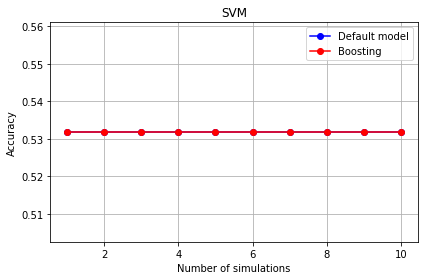

SVM: [0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703, 0.5317769130998703]


In [109]:
parameters = {
    'objective': 'multi:softmax',
    'num_class': 3
}

svm_accuracies = []
xgb_accuracies_11 = []

for j in range(10):
    svm_model = SVC(C=100)
    svm_model.fit(X_train, y_train)
    svm_predictions = svm_model.predict(X_test)
    svm_accuracy = accuracy_score(y_test, svm_predictions)
    svm_accuracies.append(svm_accuracy)

    xgb_model_svm = xgb.train(parameters, xgb.DMatrix(svm_predictions.reshape(-1, 1), label=y_test), num_boost_round=3)
    dtest_svm = xgb.DMatrix(svm_model.predict(X_test).reshape(-1, 1), label=y_test)
    xgb_predictions_svm = xgb_model_svm.predict(dtest_svm)
    xgb_accuracy_svm = accuracy_score(y_test, xgb_predictions_svm)
    xgb_accuracies_11.append(xgb_accuracy_svm)

    
plt.figure()
plt.plot(range(1, 11), svm_accuracies, 'bo-', label='Default model')
plt.plot(range(1, 11), xgb_accuracies_11, 'ro-', label='Boosting')
plt.title('SVM')
plt.xlabel('Number of simulations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Boosting_Caruana4.jpg')
plt.show()

print(f"SVM: {xgb_accuracies_11}")

# Neural Network

In [6]:
X_validate = np.array(X_validate)
X_test_validate = np.array(X_test_validate)
y_validate_categorical = to_categorical(y_validate)
y_test_validate_categorical = to_categorical(y_test_validate)

Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.8888 - accuracy: 0.3164
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.7839 - accuracy: 0.4150
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.7213 - accuracy: 0.4706
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.6845 - accuracy: 0.4852
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.6468 - accuracy: 0.4994
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.6181 - accuracy: 0.5095
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.5963 - accuracy: 0.5152
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.5814 - accuracy: 0.5063
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.5477 - accuracy: 0.5059
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.5002 - accuracy: 0.5267
Epoch 1/10
78/78 [=

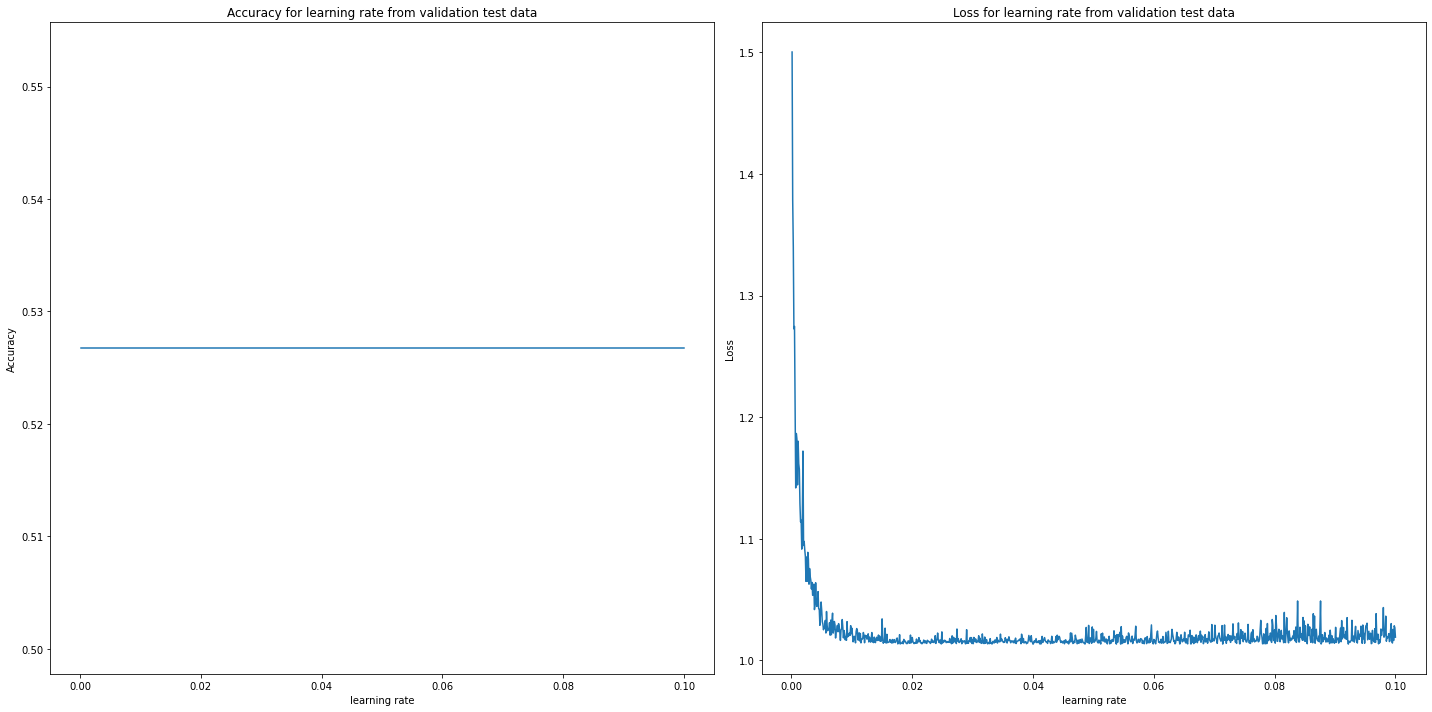

Best learning_rate: 0.04
Best loss: 1.0133628845214844
Best accuracy: 0.5267422795295715


In [7]:
custom_lr = [i/10000 for i in range(1, 1001)]
loss_list = []
accuracy_list = []

for j in custom_lr:
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.05))
    model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.02))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=j)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].plot(custom_lr, accuracy_list)
axes[0].set_title('Accuracy for learning rate from validation test data')
axes[0].set_xlabel('learning rate')
axes[0].set_ylabel('Accuracy')

axes[1].plot(custom_lr, loss_list)
axes[1].set_title('Loss for learning rate from validation test data')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_custom_lr = list(zip(loss_list, accuracy_list))
full_custom_lr = np.array(full_custom_lr) 

best_accuracy_indices = np.where(full_custom_lr[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_custom_lr[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_custom_lr[best_index, 0]
best_accuracy = full_custom_lr[best_index, 1]
best_learning_rate = custom_lr[best_index]
print(f'Best learning_rate: {best_learning_rate}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.2004 - accuracy: 0.4990
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0318 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 1ms/step - loss: 1.0196 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 1ms/step - loss: 1.0152 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 1ms/step - loss: 1.0142 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0149 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0149 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0134 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0142 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0146 - accuracy: 0.5267
Epoch 1/10
78/78 [=

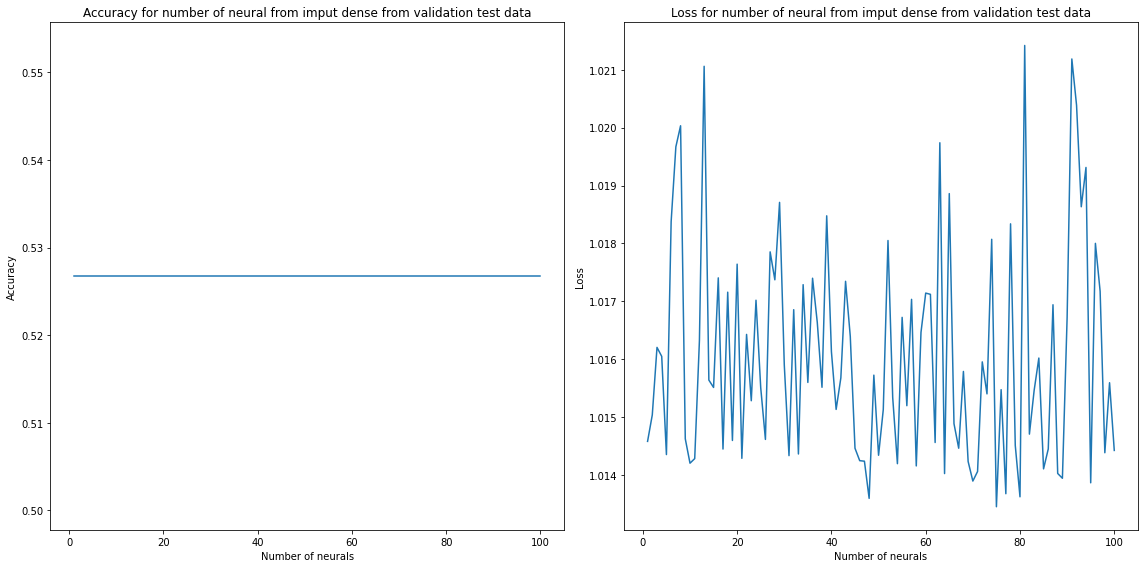

Best Number of neurons: 75
Best loss: 1.0134493112564087
Best accuracy: 0.5267422795295715


In [8]:
layer1_neuron = [i for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in layer1_neuron:
    model = Sequential()
    model.add(Dense(j, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.05))
    model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.02))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(layer1_neuron, accuracy_list)
axes[0].set_title('Accuracy for number of neural from imput dense from validation test data')
axes[0].set_xlabel('Number of neurals')
axes[0].set_ylabel('Accuracy')

axes[1].plot(layer1_neuron, loss_list)
axes[1].set_title('Loss for number of neural from imput dense from validation test data')
axes[1].set_xlabel('Number of neurals')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

full_layer1_neuron = list(zip(loss_list, accuracy_list))
full_layer1_neuron = np.array(full_layer1_neuron) 

best_accuracy_indices = np.where(full_layer1_neuron[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_layer1_neuron[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_layer1_neuron[best_index, 0]
best_accuracy = full_layer1_neuron[best_index, 1]
best_number_neuron = layer1_neuron[best_index]
print(f'Best Number of neurons: {best_number_neuron}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.4051 - accuracy: 0.5071
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.1550 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0576 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0388 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0357 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0250 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0189 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0271 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0159 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0167 - accuracy: 0.5267
Epoch 1/10
78/78 [=

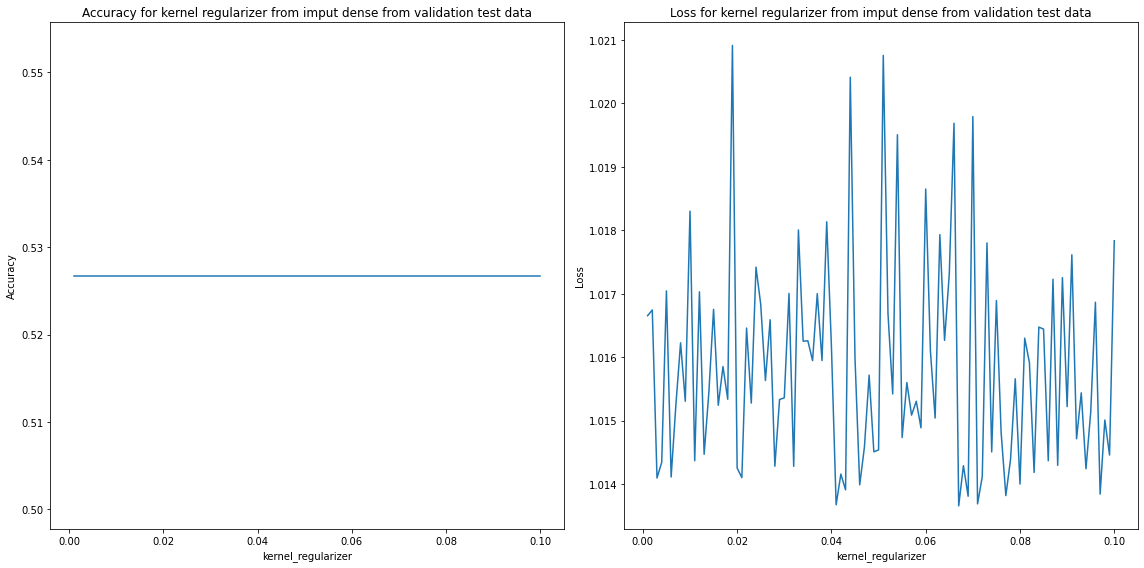

Best kernel_regularizer: 0.067
Best loss: 1.0136574506759644
Best accuracy: 0.5267422795295715


In [9]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(j)))
    model.add(Dropout(0.05))
    model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.02))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from imput dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from imput dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('NN3.jpg')
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.6878 - accuracy: 0.5140
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.2271 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0871 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0499 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0350 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0273 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0205 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0180 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0159 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0168 - accuracy: 0.5267
Epoch 1/10
78/78 [=

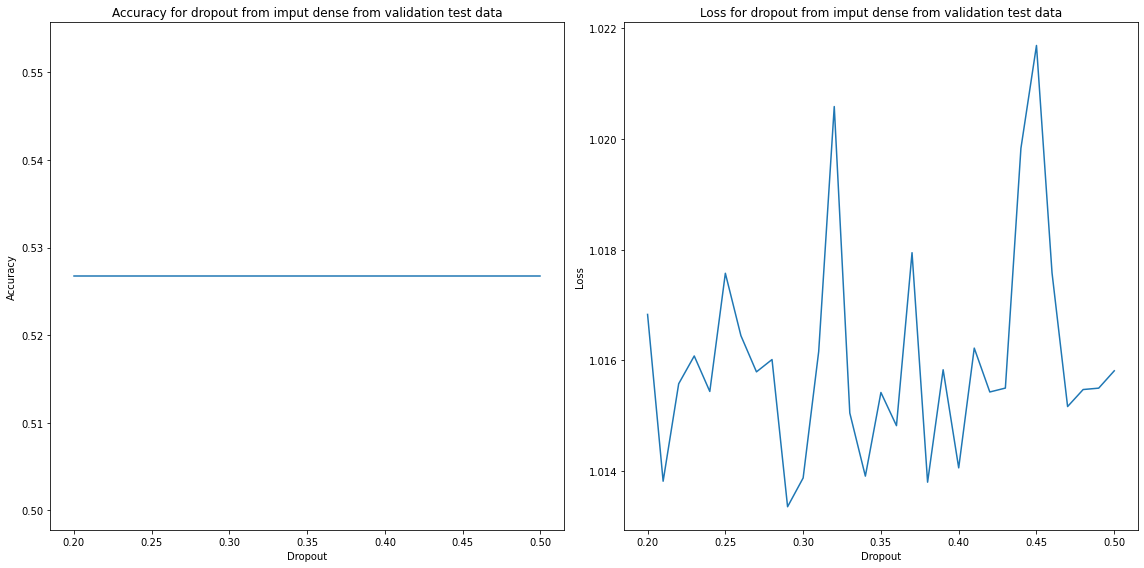

Best Dropout: 0.29
Best loss: 1.0133578777313232
Best accuracy: 0.5267422795295715


In [10]:
Dropout_list = [i/100 for i in range(20, 51)]
loss_list = []
accuracy_list = []

for j in Dropout_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(j))
    model.add(Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.02))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(Dropout_list, accuracy_list)
axes[0].set_title('Accuracy for dropout from imput dense from validation test data')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Accuracy')

axes[1].plot(Dropout_list, loss_list)
axes[1].set_title('Loss for dropout from imput dense from validation test data')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_Dropout_list = list(zip(loss_list, accuracy_list))
full_Dropout_list = np.array(full_Dropout_list) 

best_accuracy_indices = np.where(full_Dropout_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_Dropout_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_Dropout_list[best_index, 0]
best_accuracy = full_Dropout_list[best_index, 1]
best_Dropout = Dropout_list[best_index]
print(f'Best Dropout: {best_Dropout}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.0491 - accuracy: 0.5290
Epoch 2/10
78/78 [==============================] - 0s 1ms/step - loss: 1.0284 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0128 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 6ms/step - loss: 1.0156 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0110 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0134 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0121 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0126 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 1ms/step - loss: 1.0115 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0135 - accuracy: 0.5267
Epoch 1/10
78/78 [=

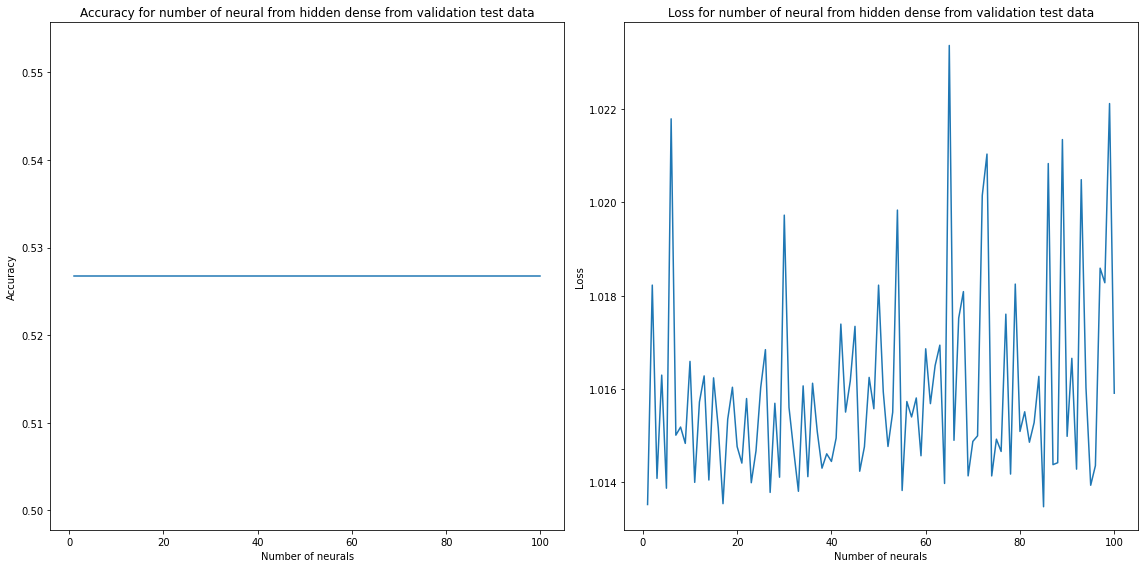

Best Number of neurons: 85
Best loss: 1.013479232788086
Best accuracy: 0.5267422795295715


In [11]:
layer1_neuron = [i for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in layer1_neuron:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.29))
    model.add(Dense(j, activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.02))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(layer1_neuron, accuracy_list)
axes[0].set_title('Accuracy for number of neural from hidden dense from validation test data')
axes[0].set_xlabel('Number of neurals')
axes[0].set_ylabel('Accuracy')

axes[1].plot(layer1_neuron, loss_list)
axes[1].set_title('Loss for number of neural from hidden dense from validation test data')
axes[1].set_xlabel('Number of neurals')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

full_layer1_neuron = list(zip(loss_list, accuracy_list))
full_layer1_neuron = np.array(full_layer1_neuron) 

best_accuracy_indices = np.where(full_layer1_neuron[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_layer1_neuron[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_layer1_neuron[best_index, 0]
best_accuracy = full_layer1_neuron[best_index, 1]
best_number_neuron = layer1_neuron[best_index]
print(f'Best Number of neurons: {best_number_neuron}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.4300 - accuracy: 0.5197
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0703 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0436 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0317 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0280 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0239 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0235 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0203 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0180 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0215 - accuracy: 0.5267
Epoch 1/10
78/78 [=

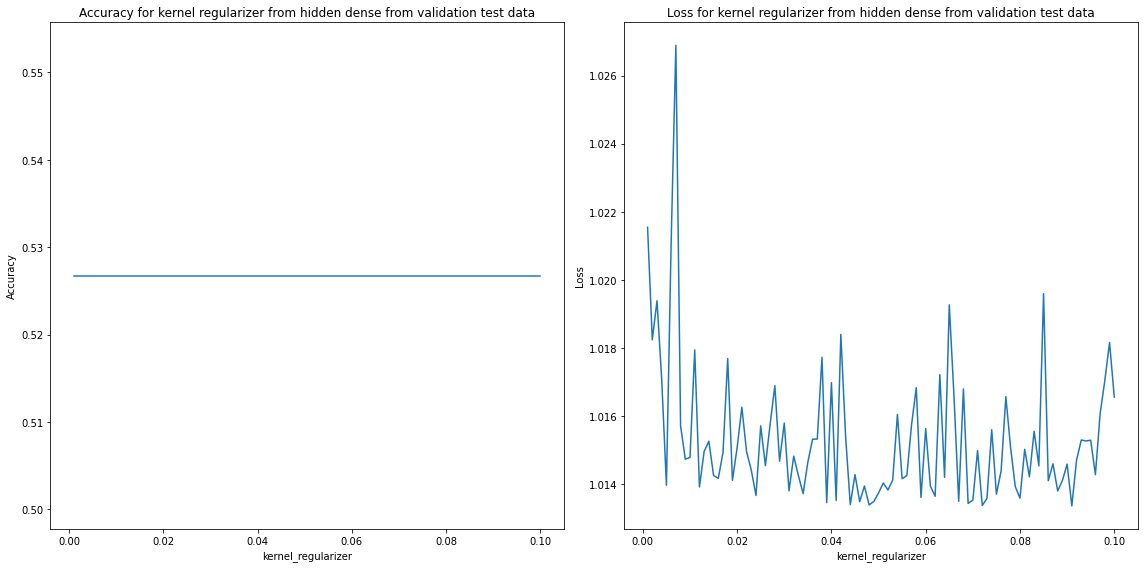

Best kernel_regularizer: 0.091
Best loss: 1.0133626461029053
Best accuracy: 0.5267422795295715


In [20]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.29))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(j)))
    model.add(Dropout(0.02))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from hidden dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from hidden dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 2.1639 - accuracy: 0.5225
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.1446 - accuracy: 0.5290
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0172 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0170 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0138 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0128 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0147 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0119 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0140 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0149 - accuracy: 0.5267
Epoch 1/10
78/78 [=

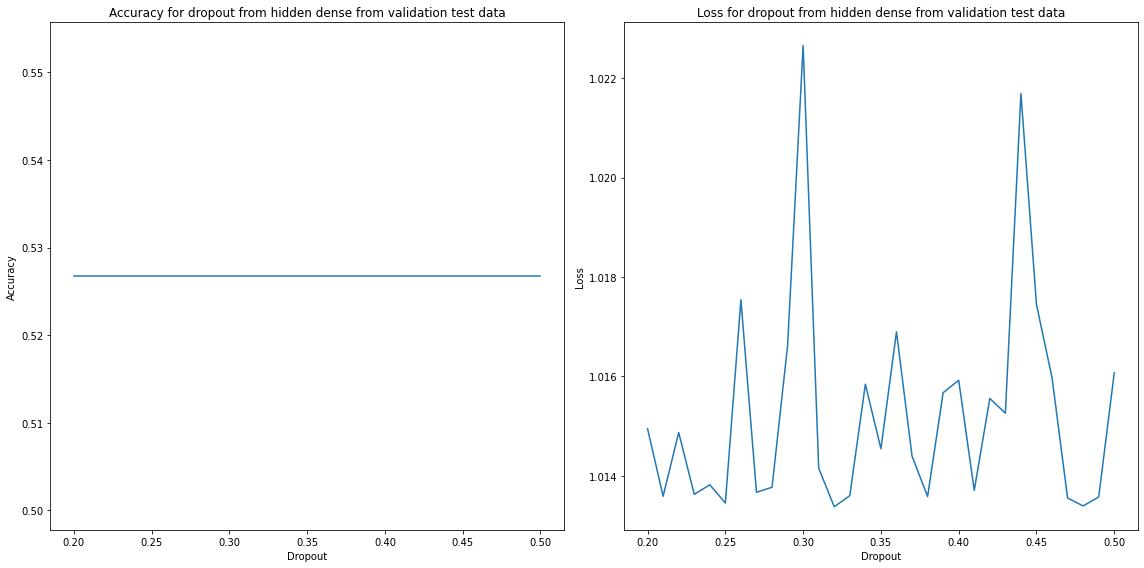

Best Dropout: 0.32
Best loss: 1.013378620147705
Best accuracy: 0.5267422795295715


In [21]:
Dropout_list = [i/100 for i in range(20, 51)]
loss_list = []
accuracy_list = []

for j in Dropout_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.29))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(j))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(Dropout_list, accuracy_list)
axes[0].set_title('Accuracy for dropout from hidden dense from validation test data')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Accuracy')

axes[1].plot(Dropout_list, loss_list)
axes[1].set_title('Loss for dropout from hidden dense from validation test data')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_Dropout_list = list(zip(loss_list, accuracy_list))
full_Dropout_list = np.array(full_Dropout_list) 

best_accuracy_indices = np.where(full_Dropout_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_Dropout_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_Dropout_list[best_index, 0]
best_accuracy = full_Dropout_list[best_index, 1]
best_Dropout = Dropout_list[best_index]
print(f'Best Dropout: {best_Dropout}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 2.2313 - accuracy: 0.5168
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.4464 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.1005 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0246 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0155 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0151 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0125 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0149 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0139 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0146 - accuracy: 0.5267
Epoch 1/10
78/78 [=

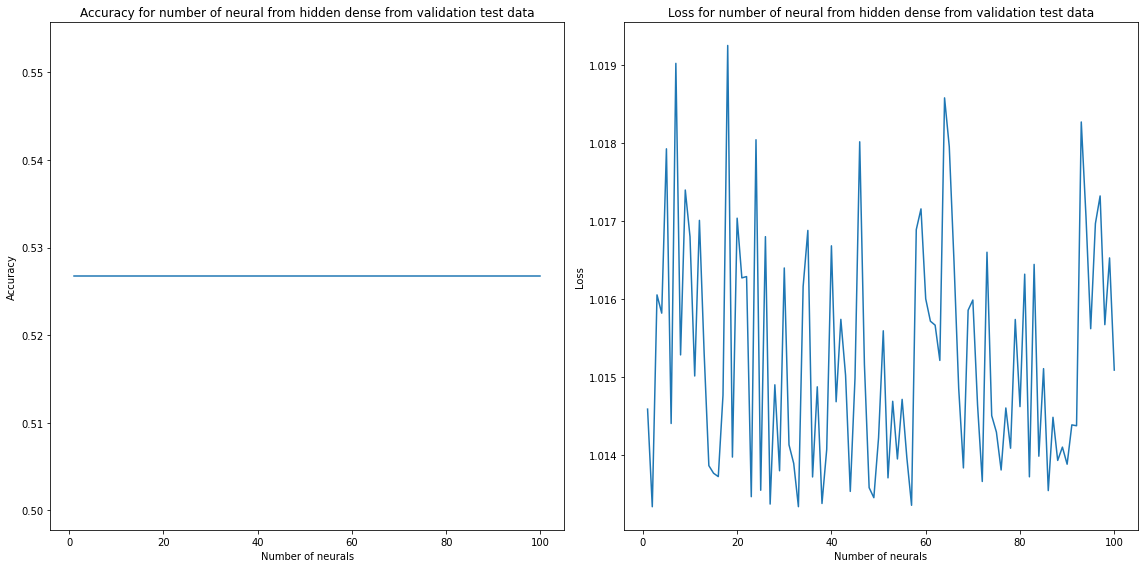

Best Number of neurons: 2
Best loss: 1.0133379697799683
Best accuracy: 0.5267422795295715


In [23]:
layer1_neuron = [i for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in layer1_neuron:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(j, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(layer1_neuron, accuracy_list)
axes[0].set_title('Accuracy for number of neural from hidden dense from validation test data')
axes[0].set_xlabel('Number of neurals')
axes[0].set_ylabel('Accuracy')

axes[1].plot(layer1_neuron, loss_list)
axes[1].set_title('Loss for number of neural from hidden dense from validation test data')
axes[1].set_xlabel('Number of neurals')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

full_layer1_neuron = list(zip(loss_list, accuracy_list))
full_layer1_neuron = np.array(full_layer1_neuron) 

best_accuracy_indices = np.where(full_layer1_neuron[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_layer1_neuron[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_layer1_neuron[best_index, 0]
best_accuracy = full_layer1_neuron[best_index, 1]
best_number_neuron = layer1_neuron[best_index]
print(f'Best Number of neurons: {best_number_neuron}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 2.6335 - accuracy: 0.5059
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.4516 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0503 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0169 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0147 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0126 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0131 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0107 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0115 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0152 - accuracy: 0.5267
Epoch 1/10
78/78 [=

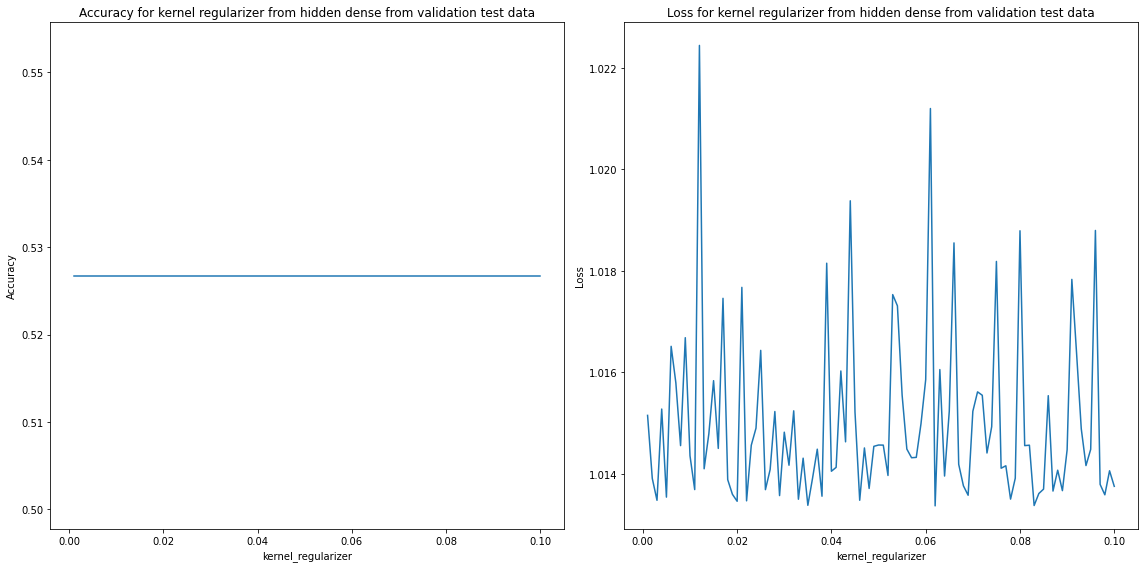

Best kernel_regularizer: 0.062
Best loss: 1.0133675336837769
Best accuracy: 0.5267422795295715


In [24]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(j)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from hidden dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from hidden dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 1.9092 - accuracy: 0.5306
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0676 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0140 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0147 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0112 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0135 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0121 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0119 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0135 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0143 - accuracy: 0.5267
Epoch 1/10
78/78 [=

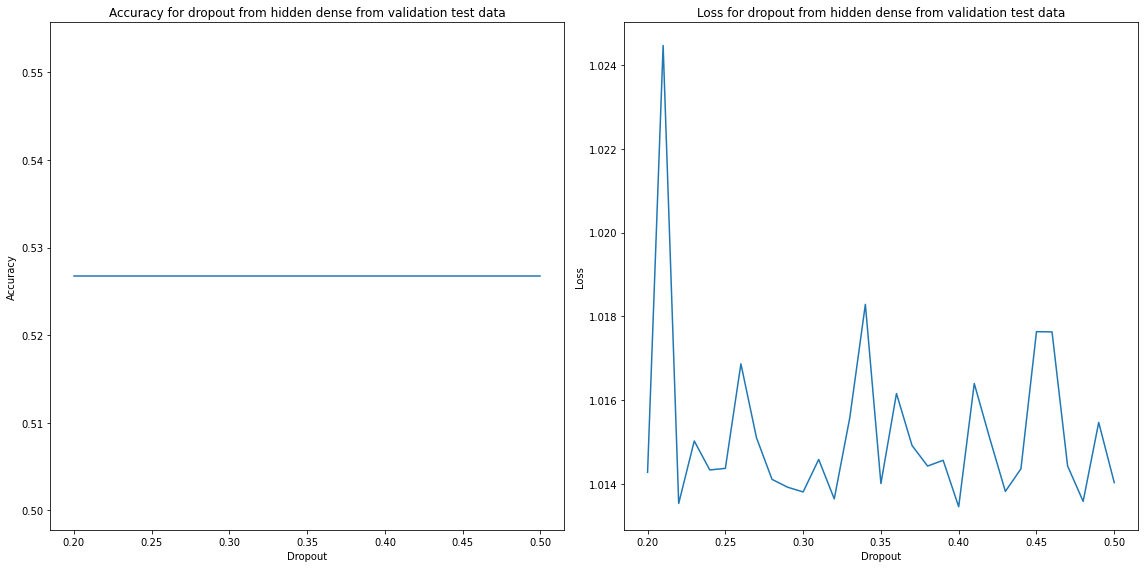

Best Dropout: 0.4
Best loss: 1.0134515762329102
Best accuracy: 0.5267422795295715


In [25]:
Dropout_list = [i/100 for i in range(20, 51)]
loss_list = []
accuracy_list = []

for j in Dropout_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(j))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(Dropout_list, accuracy_list)
axes[0].set_title('Accuracy for dropout from hidden dense from validation test data')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Accuracy')

axes[1].plot(Dropout_list, loss_list)
axes[1].set_title('Loss for dropout from hidden dense from validation test data')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_Dropout_list = list(zip(loss_list, accuracy_list))
full_Dropout_list = np.array(full_Dropout_list) 

best_accuracy_indices = np.where(full_Dropout_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_Dropout_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_Dropout_list[best_index, 0]
best_accuracy = full_Dropout_list[best_index, 1]
best_Dropout = Dropout_list[best_index]
print(f'Best Dropout: {best_Dropout}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 1s 2ms/step - loss: 2.1777 - accuracy: 0.5197
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0936 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0264 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0169 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0130 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0143 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0118 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0121 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0134 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0150 - accuracy: 0.5267
Epoch 1/10
78/78 [=

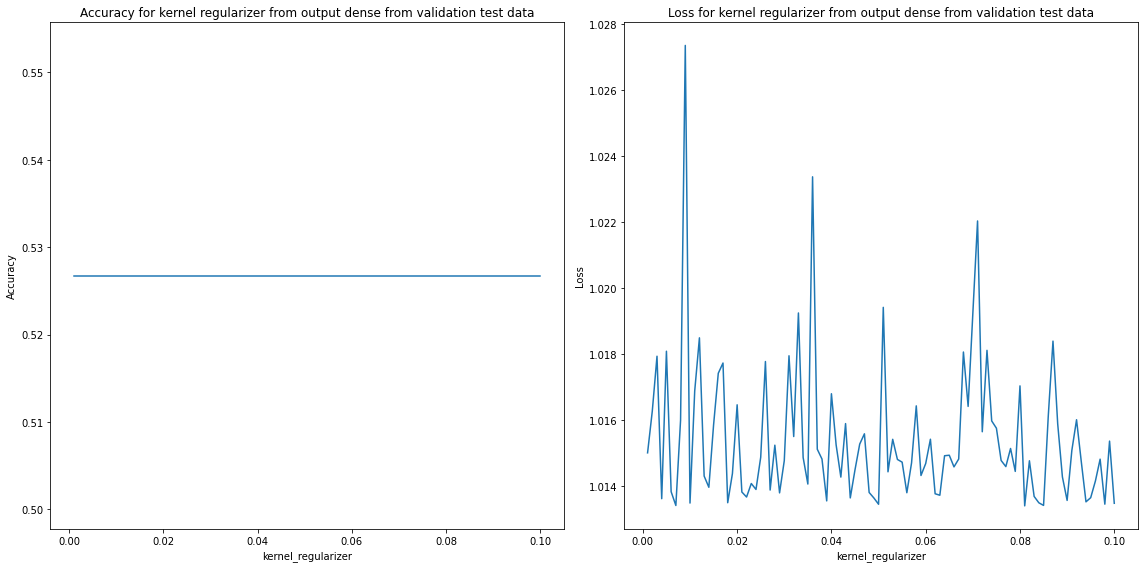

Best kernel_regularizer: 0.081
Best loss: 1.013409972190857
Best accuracy: 0.5267422795295715


In [31]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_validate.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(j)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from output dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from output dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

In [27]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

Epoch 1/50
97/97 [==============================] - 1s 2ms/step - loss: 1.8098 - accuracy: 0.5240
Epoch 2/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0346 - accuracy: 0.5302
Epoch 3/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0136 - accuracy: 0.5302
Epoch 4/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0130 - accuracy: 0.5302
Epoch 5/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0127 - accuracy: 0.5302
Epoch 6/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0128 - accuracy: 0.5302
Epoch 7/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0116 - accuracy: 0.5302
Epoch 8/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0155 - accuracy: 0.5302
Epoch 9/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0117 - accuracy: 0.5302
Epoch 10/50
97/97 [==============================] - 0s 2ms/step - loss: 1.0136 - accuracy: 0.5302
Epoch 11/50
97/97 [

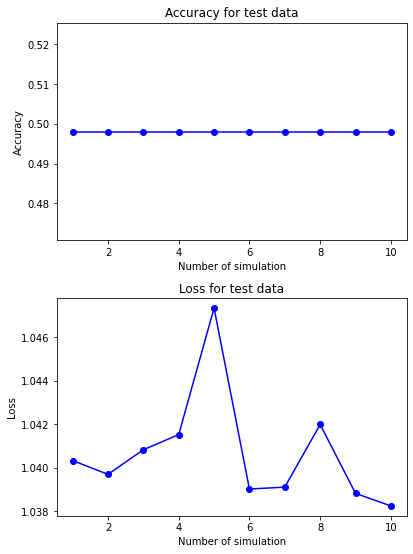

In [32]:
loss_list = []
accuracy_list = []

for i in range(10):
    model = Sequential()
    model.add(Dense(75, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train_categorical, epochs=50)

    model_score = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])
    
    
fig, axes = plt.subplots(2,1, figsize=(5.85, 7.8))
axes[0].plot(range(1,11), accuracy_list, 'bo-')
axes[0].set_title('Accuracy for test data')
axes[0].set_xlabel('Number of simulation')
axes[0].set_ylabel('Accuracy')

axes[1].plot(range(1,11), loss_list, 'bo-')
axes[1].set_title('Loss for test data')
axes[1].set_xlabel('Number of simulation')
axes[1].set_ylabel('Loss')

print(f"accuracy:{accuracy_list}")
print(f"loss:{loss_list}")

plt.tight_layout()
plt.savefig('NN_Caruana.jpg')
plt.show() 

# Simple RNN

Epoch 1/10
78/78 [==============================] - 2s 2ms/step - loss: 1.3363 - accuracy: 0.5266
Epoch 2/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0129 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0112 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0140 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0114 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0120 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0139 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0114 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 2ms/step - loss: 1.0138 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0135 - accuracy: 0.5267
Epoch 1/10
78/78 [=

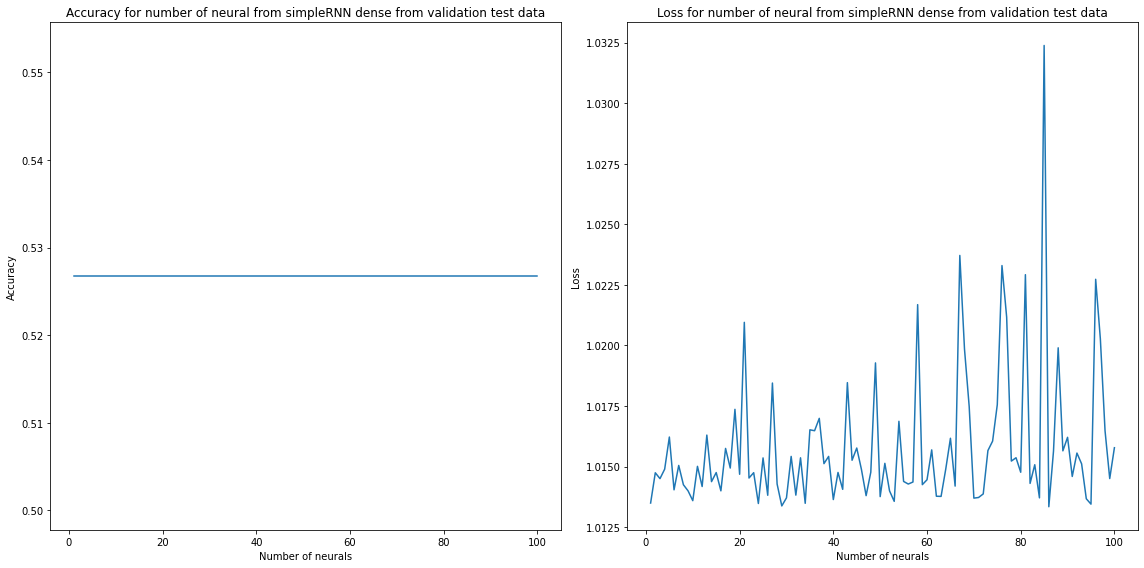

Best Number of neurons: 86
Best loss: 1.0133442878723145
Best accuracy: 0.5267422795295715


In [33]:
layer1_neuron = [i for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in layer1_neuron:
    model = Sequential()
    model.add(SimpleRNN(j, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.0617)))
    model.add(Dropout(0.35))
    model.add(Dense(75, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(layer1_neuron, accuracy_list)
axes[0].set_title('Accuracy for number of neural from simpleRNN dense from validation test data')
axes[0].set_xlabel('Number of neurals')
axes[0].set_ylabel('Accuracy')

axes[1].plot(layer1_neuron, loss_list)
axes[1].set_title('Loss for number of neural from simpleRNN dense from validation test data')
axes[1].set_xlabel('Number of neurals')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

full_layer1_neuron = list(zip(loss_list, accuracy_list))
full_layer1_neuron = np.array(full_layer1_neuron) 

best_accuracy_indices = np.where(full_layer1_neuron[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_layer1_neuron[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_layer1_neuron[best_index, 0]
best_accuracy = full_layer1_neuron[best_index, 1]
best_number_neuron = layer1_neuron[best_index]
print(f'Best Number of neurons: {best_number_neuron}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 2s 3ms/step - loss: 2.7629 - accuracy: 0.5144
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 1.1442 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0353 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0185 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0164 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0136 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0140 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0140 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0121 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0144 - accuracy: 0.5267
Epoch 1/10
78/78 [=

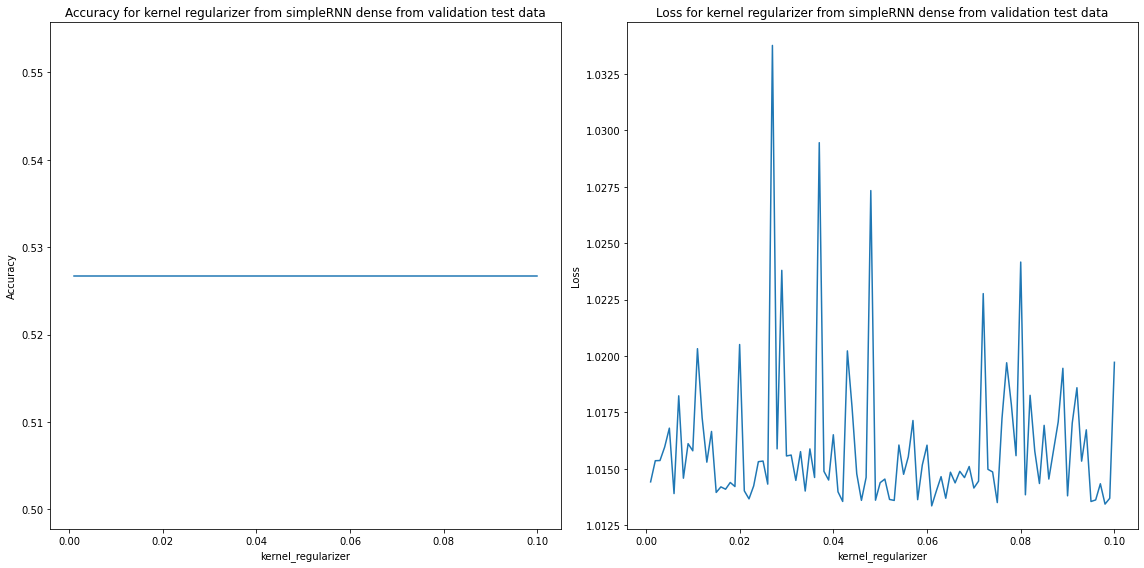

Best kernel_regularizer: 0.061
Best loss: 1.013352632522583
Best accuracy: 0.5267422795295715


In [34]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(SimpleRNN(86, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(j)))
    model.add(Dropout(0.35))
    model.add(Dense(75, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from simpleRNN dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from simpleRNN dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('RNN2.jpg')
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/10
78/78 [==============================] - 2s 3ms/step - loss: 2.4389 - accuracy: 0.5270
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 1.1380 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0407 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0230 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0174 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0188 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0126 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0136 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0120 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0138 - accuracy: 0.5267
Epoch 1/10
78/78 [=

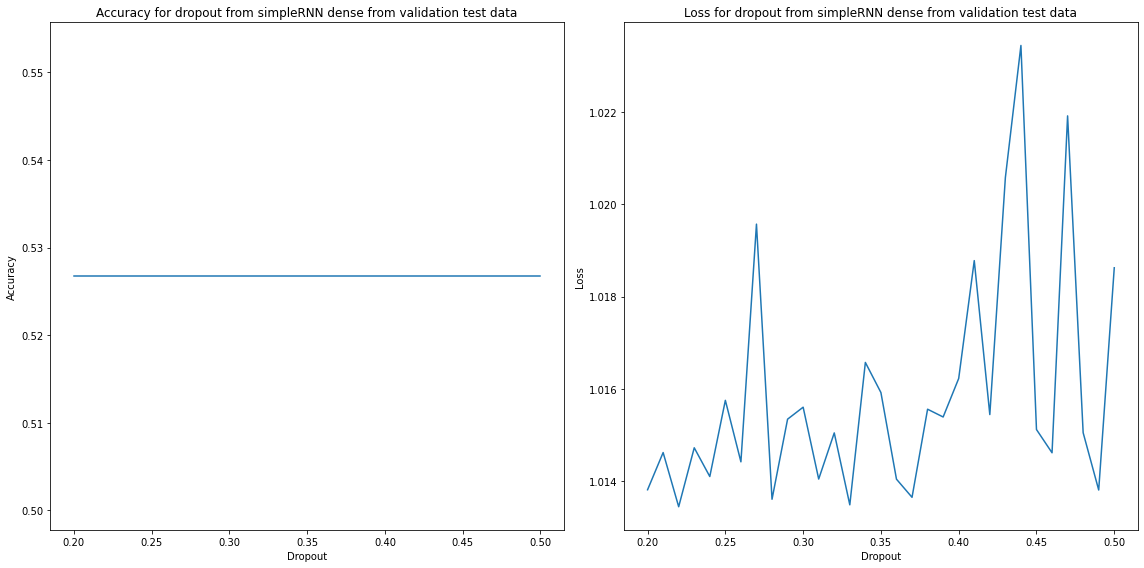

Best Dropout: 0.22
Best loss: 1.013439416885376
Best accuracy: 0.5267422795295715


In [35]:
Dropout_list = [i/100 for i in range(20, 51)]
loss_list = []
accuracy_list = []

for j in Dropout_list:
    model = Sequential()
    model.add(SimpleRNN(86, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.061)))
    model.add(Dropout(j))
    model.add(Dense(75, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(Dropout_list, accuracy_list)
axes[0].set_title('Accuracy for dropout from simpleRNN dense from validation test data')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Accuracy')

axes[1].plot(Dropout_list, loss_list)
axes[1].set_title('Loss for dropout from simpleRNN dense from validation test data')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('RNN3.jpg')
plt.show() 

full_Dropout_list = list(zip(loss_list, accuracy_list))
full_Dropout_list = np.array(full_Dropout_list) 

best_accuracy_indices = np.where(full_Dropout_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_Dropout_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_Dropout_list[best_index, 0]
best_accuracy = full_Dropout_list[best_index, 1]
best_Dropout = Dropout_list[best_index]
print(f'Best Dropout: {best_Dropout}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')


Epoch 1/50
97/97 [==============================] - 2s 3ms/step - loss: 2.8429 - accuracy: 0.5156
Epoch 2/50
97/97 [==============================] - 0s 3ms/step - loss: 1.1735 - accuracy: 0.5302
Epoch 3/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0922 - accuracy: 0.5302
Epoch 4/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0627 - accuracy: 0.5302
Epoch 5/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0461 - accuracy: 0.5302
Epoch 6/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0345 - accuracy: 0.5302
Epoch 7/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0261 - accuracy: 0.5302
Epoch 8/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0217 - accuracy: 0.5302
Epoch 9/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0179 - accuracy: 0.5302
Epoch 10/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0157 - accuracy: 0.5302
Epoch 11/50
97/97 [

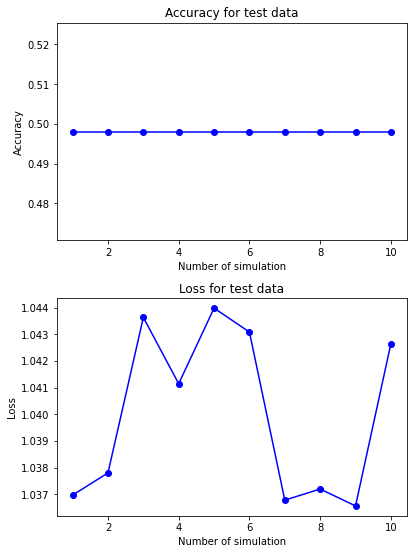

accuracy:[0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886]
loss:[1.0369666814804077, 1.0377980470657349, 1.0436289310455322, 1.0411418676376343, 1.0439791679382324, 1.0430798530578613, 1.0367772579193115, 1.0371934175491333, 1.0365607738494873, 1.0426435470581055]


In [36]:
loss_list = []
accuracy_list = []

for i in range(10):
    model = Sequential()
    model.add(SimpleRNN(86, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.061)))
    model.add(Dropout(0.22))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train_categorical, epochs=50)

    model_score = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(2,1, figsize=(5.85, 7.8))
axes[0].plot(range(1,11), accuracy_list, 'bo-')
axes[0].set_title('Accuracy for test data')
axes[0].set_xlabel('Number of simulation')
axes[0].set_ylabel('Accuracy')

axes[1].plot(range(1,11), loss_list, 'bo-')
axes[1].set_title('Loss for test data')
axes[1].set_xlabel('Number of simulation')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('RNN_Caruana.jpg')
plt.show() 

print(f"accuracy:{accuracy_list}")
print(f"loss:{loss_list}")

# LSTM

Epoch 1/10
78/78 [==============================] - 2s 4ms/step - loss: 1.4007 - accuracy: 0.5266
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0135 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0118 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0133 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 5ms/step - loss: 1.0112 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0106 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0136 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0144 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0122 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0148 - accuracy: 0.5267
Epoch 1/10
78/78 [=

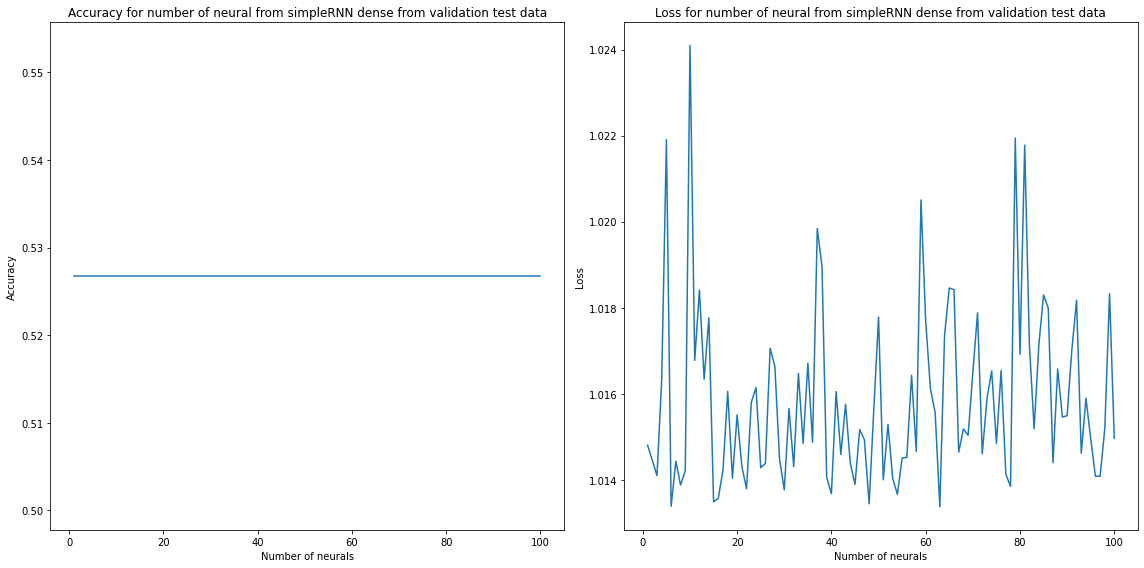

Best Number of neurons: 63
Best loss: 1.013375163078308
Best accuracy: 0.5267422795295715


In [37]:
layer1_neuron = [i for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in layer1_neuron:
    model = Sequential()
    model.add(LSTM(j, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.0409)))
    model.add(Dropout(0.23))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(layer1_neuron, accuracy_list)
axes[0].set_title('Accuracy for number of neural from simpleRNN dense from validation test data')
axes[0].set_xlabel('Number of neurals')
axes[0].set_ylabel('Accuracy')

axes[1].plot(layer1_neuron, loss_list)
axes[1].set_title('Loss for number of neural from simpleRNN dense from validation test data')
axes[1].set_xlabel('Number of neurals')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

full_layer1_neuron = list(zip(loss_list, accuracy_list))
full_layer1_neuron = np.array(full_layer1_neuron) 

best_accuracy_indices = np.where(full_layer1_neuron[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_layer1_neuron[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_layer1_neuron[best_index, 0]
best_accuracy = full_layer1_neuron[best_index, 1]
best_number_neuron = layer1_neuron[best_index]
print(f'Best Number of neurons: {best_number_neuron}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 2s 4ms/step - loss: 2.8321 - accuracy: 0.5006
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 1.1384 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0195 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0158 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0162 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0137 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0141 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0115 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0142 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0152 - accuracy: 0.5267
Epoch 1/10
78/78 [=

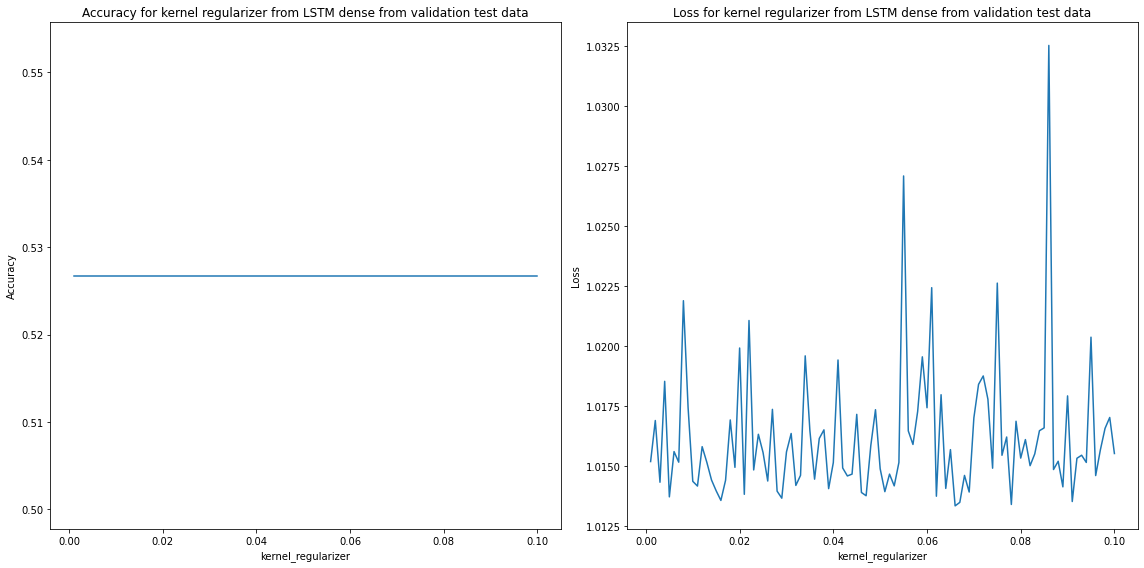

Best kernel_regularizer: 0.066
Best loss: 1.0133434534072876
Best accuracy: 0.5267422795295715


In [38]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(LSTM(63, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(j)))
    model.add(Dropout(0.23))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)


    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from LSTM dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from LSTM dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('LSTM2.jpg')
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 2s 4ms/step - loss: 2.5796 - accuracy: 0.5266
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0943 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0364 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0282 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0224 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0232 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0182 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0186 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0160 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0187 - accuracy: 0.5267
Epoch 1/10
78/78 [=

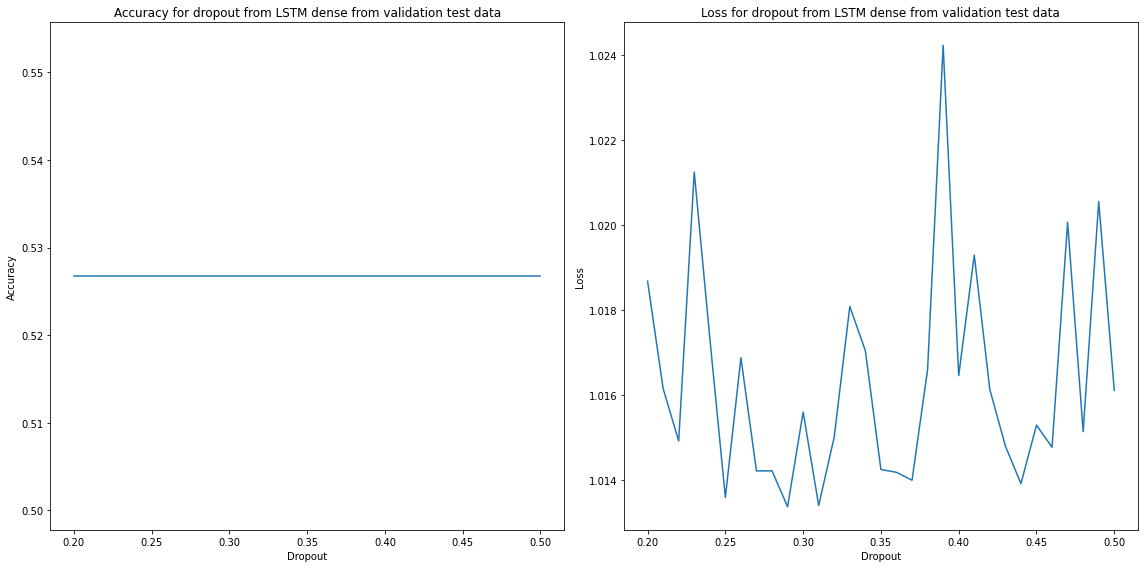

Best Dropout: 0.29
Best loss: 1.013380527496338
Best accuracy: 0.5267422795295715


In [39]:
Dropout_list = [i/100 for i in range(20, 51)]
loss_list = []
accuracy_list = []

for j in Dropout_list:
    model = Sequential()
    model.add(LSTM(63, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.066)))
    model.add(Dropout(j))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)


    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(Dropout_list, accuracy_list)
axes[0].set_title('Accuracy for dropout from LSTM dense from validation test data')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Accuracy')

axes[1].plot(Dropout_list, loss_list)
axes[1].set_title('Loss for dropout from LSTM dense from validation test data')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_Dropout_list = list(zip(loss_list, accuracy_list))
full_Dropout_list = np.array(full_Dropout_list) 

best_accuracy_indices = np.where(full_Dropout_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_Dropout_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_Dropout_list[best_index, 0]
best_accuracy = full_Dropout_list[best_index, 1]
best_Dropout = Dropout_list[best_index]
print(f'Best Dropout: {best_Dropout}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/50
97/97 [==============================] - 2s 3ms/step - loss: 1.9927 - accuracy: 0.5237
Epoch 2/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0252 - accuracy: 0.5302
Epoch 3/50
97/97 [==============================] - 0s 4ms/step - loss: 1.0172 - accuracy: 0.5302
Epoch 4/50
97/97 [==============================] - 0s 4ms/step - loss: 1.0153 - accuracy: 0.5302
Epoch 5/50
97/97 [==============================] - 0s 4ms/step - loss: 1.0149 - accuracy: 0.5302
Epoch 6/50
97/97 [==============================] - 0s 4ms/step - loss: 1.0143 - accuracy: 0.5302
Epoch 7/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0143 - accuracy: 0.5302
Epoch 8/50
97/97 [==============================] - 0s 4ms/step - loss: 1.0122 - accuracy: 0.5302
Epoch 9/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0115 - accuracy: 0.5302
Epoch 10/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0130 - accuracy: 0.5302
Epoch 11/50
97/97 [

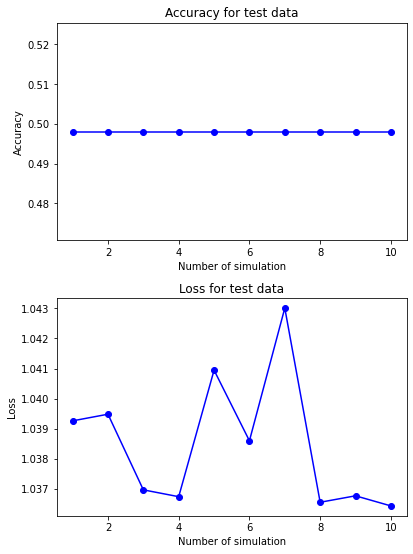

accuracy:[0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886]
loss:[1.0392630100250244, 1.0394830703735352, 1.0369725227355957, 1.0367459058761597, 1.0409449338912964, 1.0386011600494385, 1.0430049896240234, 1.0365606546401978, 1.0367748737335205, 1.0364397764205933]


In [40]:
loss_list = []
accuracy_list = []

for i in range(10):
    model = Sequential()
    model.add(LSTM(63, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.066)))
    model.add(Dropout(0.29))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)


    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train_categorical, epochs=50)

    model_score = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(2,1, figsize=(5.85, 7.8))
axes[0].plot(range(1,11), accuracy_list, 'bo-')
axes[0].set_title('Accuracy for test data')
axes[0].set_xlabel('Number of simulation')
axes[0].set_ylabel('Accuracy')

axes[1].plot(range(1,11), loss_list, 'bo-')
axes[1].set_title('Loss for test data')
axes[1].set_xlabel('Number of simulation')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('LSTM_Caruana.jpg')
plt.show() 

print(f"accuracy:{accuracy_list}")
print(f"loss:{loss_list}")

# GRU

Epoch 1/10
78/78 [==============================] - 2s 3ms/step - loss: 1.3510 - accuracy: 0.5241
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0142 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0108 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0127 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0118 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0125 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0132 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0116 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0125 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 1ms/step - loss: 1.0153 - accuracy: 0.5267
Epoch 1/10
78/78 [=

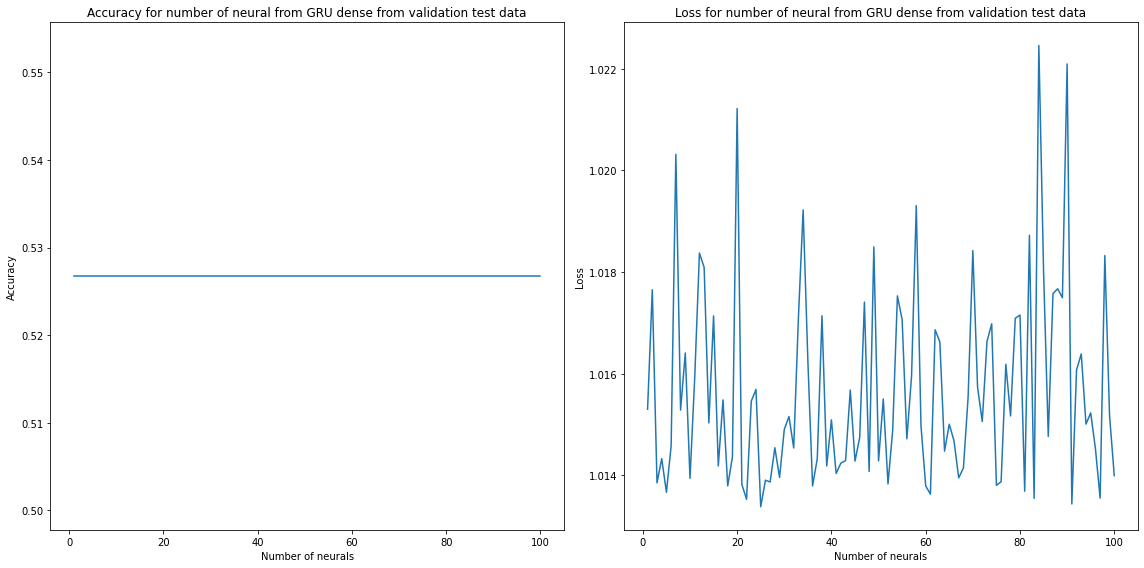

Best Number of neurons: 25
Best loss: 1.0133835077285767
Best accuracy: 0.5267422795295715


In [41]:
layer1_neuron = [i for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in layer1_neuron:
    model = Sequential()
    model.add(GRU(j, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.0409)))
    model.add(Dropout(0.23))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(layer1_neuron, accuracy_list)
axes[0].set_title('Accuracy for number of neural from GRU dense from validation test data')
axes[0].set_xlabel('Number of neurals')
axes[0].set_ylabel('Accuracy')

axes[1].plot(layer1_neuron, loss_list)
axes[1].set_title('Loss for number of neural from GRU dense from validation test data')
axes[1].set_xlabel('Number of neurals')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

full_layer1_neuron = list(zip(loss_list, accuracy_list))
full_layer1_neuron = np.array(full_layer1_neuron) 

best_accuracy_indices = np.where(full_layer1_neuron[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_layer1_neuron[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_layer1_neuron[best_index, 0]
best_accuracy = full_layer1_neuron[best_index, 1]
best_number_neuron = layer1_neuron[best_index]
print(f'Best Number of neurons: {best_number_neuron}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 2s 3ms/step - loss: 2.9718 - accuracy: 0.5262
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 1.1613 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0366 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0196 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0149 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 1.0137 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 5ms/step - loss: 1.0137 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 5ms/step - loss: 1.0156 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0129 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0147 - accuracy: 0.5267
Epoch 1/10
78/78 [=

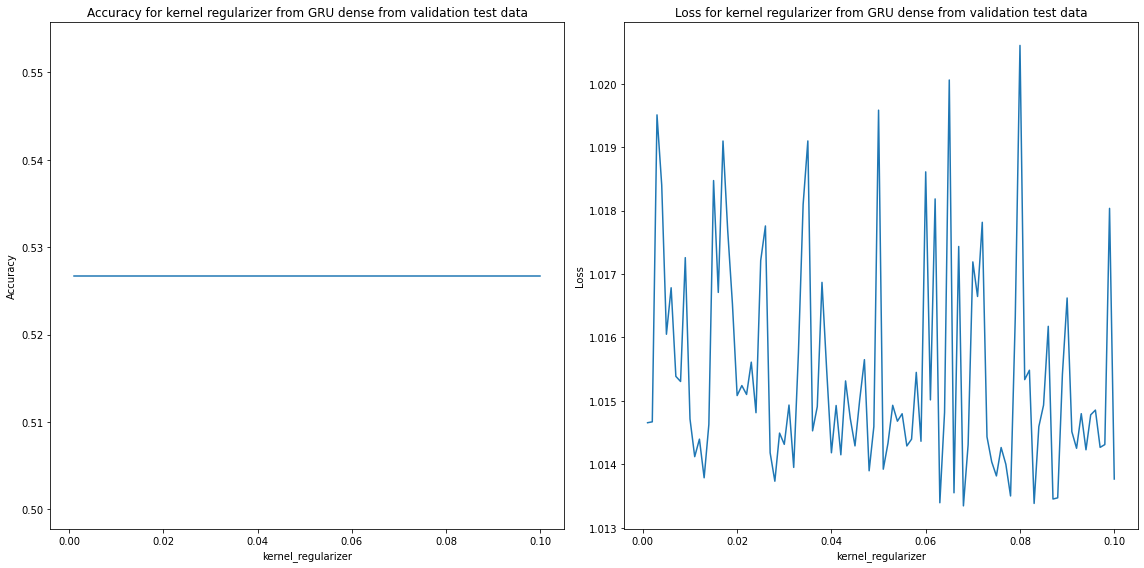

Best kernel_regularizer: 0.068
Best loss: 1.0133451223373413
Best accuracy: 0.5267422795295715


In [42]:
kernel_regularizer_list = [i/1000 for i in range(1, 101)]
loss_list = []
accuracy_list = []

for j in kernel_regularizer_list:
    model = Sequential()
    model.add(GRU(62, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(j)))
    model.add(Dropout(0.23))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(kernel_regularizer_list, accuracy_list)
axes[0].set_title('Accuracy for kernel regularizer from GRU dense from validation test data')
axes[0].set_xlabel('kernel_regularizer')
axes[0].set_ylabel('Accuracy')

axes[1].plot(kernel_regularizer_list, loss_list)
axes[1].set_title('Loss for kernel regularizer from GRU dense from validation test data')
axes[1].set_xlabel('kernel_regularizer')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_kernel_regularizer_list = list(zip(loss_list, accuracy_list))
full_kernel_regularizer_list = np.array(full_kernel_regularizer_list) 

best_accuracy_indices = np.where(full_kernel_regularizer_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_kernel_regularizer_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_kernel_regularizer_list[best_index, 0]
best_accuracy = full_kernel_regularizer_list[best_index, 1]
best_kernel_regularizer = kernel_regularizer_list[best_index]
print(f'Best kernel_regularizer: {best_kernel_regularizer}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/10
78/78 [==============================] - 3s 4ms/step - loss: 3.6498 - accuracy: 0.5091
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 1.3794 - accuracy: 0.5310
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0970 - accuracy: 0.5310
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0460 - accuracy: 0.5310
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0309 - accuracy: 0.5310
Epoch 6/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0233 - accuracy: 0.5310
Epoch 7/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0227 - accuracy: 0.5310
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0224 - accuracy: 0.5310
Epoch 9/10
78/78 [==============================] - 0s 4ms/step - loss: 1.0162 - accuracy: 0.5310
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 1.0170 - accuracy: 0.5267
Epoch 1/10
78/78 [=

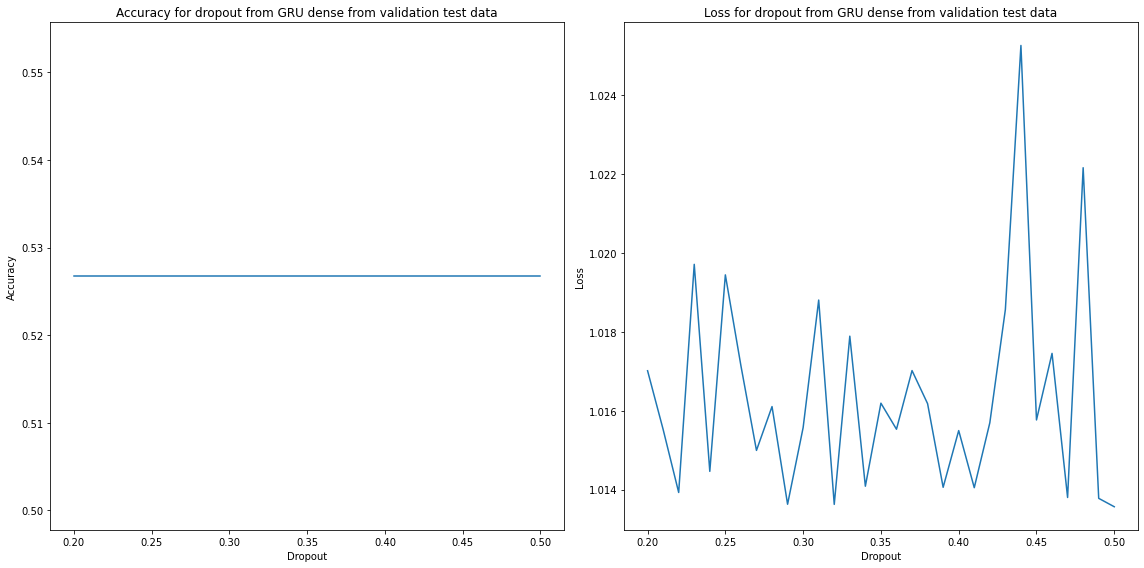

Best Dropout: 0.5
Best loss: 1.0135645866394043
Best accuracy: 0.5267422795295715


In [43]:
Dropout_list = [i/100 for i in range(20, 51)]
loss_list = []
accuracy_list = []

for j in Dropout_list:
    model = Sequential()
    model.add(GRU(62, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.068)))
    model.add(Dropout(j))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_validate, y_validate_categorical, epochs=10)

    model_score = model.evaluate(X_test_validate, y_test_validate_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(Dropout_list, accuracy_list)
axes[0].set_title('Accuracy for dropout from GRU dense from validation test data')
axes[0].set_xlabel('Dropout')
axes[0].set_ylabel('Accuracy')

axes[1].plot(Dropout_list, loss_list)
axes[1].set_title('Loss for dropout from GRU dense from validation test data')
axes[1].set_xlabel('Dropout')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show() 

full_Dropout_list = list(zip(loss_list, accuracy_list))
full_Dropout_list = np.array(full_Dropout_list) 

best_accuracy_indices = np.where(full_Dropout_list[:, 1] == max(accuracy_list))[0]
best_loss_index = np.argmin(full_Dropout_list[best_accuracy_indices, 0])
best_index = best_accuracy_indices[best_loss_index]
best_loss = full_Dropout_list[best_index, 0]
best_accuracy = full_Dropout_list[best_index, 1]
best_Dropout = Dropout_list[best_index]
print(f'Best Dropout: {best_Dropout}')
print(f'Best loss: {best_loss}')
print(f'Best accuracy: {best_accuracy}')

Epoch 1/50
97/97 [==============================] - 2s 3ms/step - loss: 1.9472 - accuracy: 0.5260
Epoch 2/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0202 - accuracy: 0.5302
Epoch 3/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0161 - accuracy: 0.5302
Epoch 4/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0160 - accuracy: 0.5302
Epoch 5/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0139 - accuracy: 0.5302
Epoch 6/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0122 - accuracy: 0.5302
Epoch 7/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0153 - accuracy: 0.5302
Epoch 8/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0129 - accuracy: 0.5302
Epoch 9/50
97/97 [==============================] - 0s 3ms/step - loss: 1.0136 - accuracy: 0.5302
Epoch 10/50
97/97 [==============================] - 0s 4ms/step - loss: 1.0139 - accuracy: 0.5302
Epoch 11/50
97/97 [

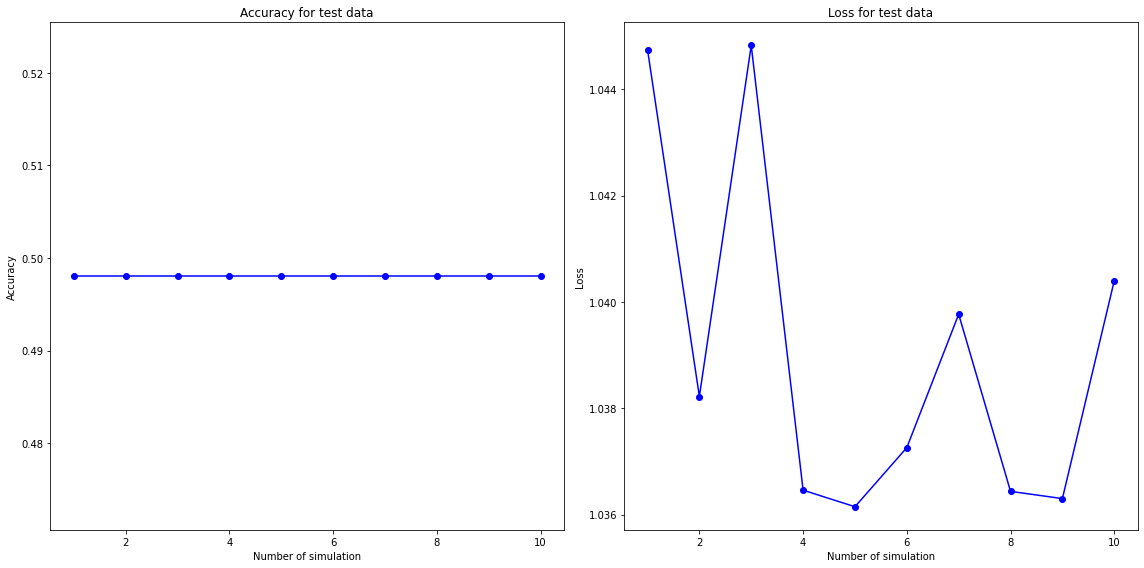

accuracy:[0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886, 0.49805447459220886]
loss:[1.0447474718093872, 1.0382198095321655, 1.0448240041732788, 1.0364582538604736, 1.036146879196167, 1.0372588634490967, 1.0397679805755615, 1.0364359617233276, 1.0363000631332397, 1.040398120880127]


In [44]:
loss_list = []
accuracy_list = []

for i in range(10):
    model = Sequential()
    model.add(GRU(62, activation='relu', input_shape=(X_validate.shape[1], 1), kernel_regularizer=regularizers.l2(0.068)))
    model.add(Dropout(0.5))
    model.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l2(0.067)))
    model.add(Dropout(0.36))
    model.add(Dense(70, activation='tanh', kernel_regularizer=regularizers.l2(0.091)))
    model.add(Dropout(0.32))
    model.add(Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.062)))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

    optimizer = Adam(learning_rate=0.04)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train_categorical, epochs=50)

    model_score = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test_categorical)
    loss_list.append(model_score[0])
    accuracy_list.append(model_score[1])

fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].plot(range(1,11), accuracy_list, 'bo-')
axes[0].set_title('Accuracy for test data')
axes[0].set_xlabel('Number of simulation')
axes[0].set_ylabel('Accuracy')

axes[1].plot(range(1,11), loss_list, 'bo-')
axes[1].set_title('Loss for test data')
axes[1].set_xlabel('Number of simulation')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.savefig('GRU_Caruana.jpg')
plt.show()

print(f"accuracy:{accuracy_list}")
print(f"loss:{loss_list}")